<p align="center">
          <img src="https://aws1.discourse-cdn.com/boingboing/original/3X/4/2/42f5e99d1e26bb8588c8b992c82ba4293c4ec838.jpg" width=400>
                                                                                                                            </p>

# Predicting Shark Attacks - WORK IN PROGRESS

This project will attempt to build a model that will be able to predict shark attacks based on various oceanic, astrological, meteorological, and marine life factors. 

## Data

The data used for modeling was obtained from [Kaggle](https://www.kaggle.com/dingo1694/shark-attack) and contains values collected mainly from North and South Carolina Beaches. It is important to note that 61% of the location data is Null, while the remaining 39% indicate the data was collected from the Carolinas. Because this dataset is small, this project worked under the assumption that all data was collected from this region to maintain as much data as possible.

The [Global Shark Attack File](https://www.sharkattackfile.net/incidentlog.htm) was obtained from the [Shark Research Institute](https://www.sharks.org/), an organization dedicated to "inform[ing] and guid[ing] governing bodies and society at large to conservation policies that ensure the sustainability of all shark species." This file contains roughly 4600 reported shark attacks dating back to the mid-1800's. While it does not contain the same oceanic, astrological, meteorological, or marine life measures, it does include location data, activity of the victim, and whether or not the shark was provoked. This data was used to help inform data analysis and model development.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# YOLO
import warnings
warnings.filterwarnings('ignore')

### Load Kaggle Shark Attack Data

**Encountered a UTF-8 ecoding error. The suggestions in this discussion resolved the issue:** https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python

In [2]:
data = pd.read_csv('sharks.csv', encoding='ISO-8859-1', parse_dates=['Date'])
print(data.shape)
data.head()

(186, 72)


,X.2,X.1,X,Id,Date,ID,TurtleExactCountSC,turtleexactdiscretizeSC,TurtleExactCountNC,TurtleExactCombined,...,StationPressure_minmax,WindSpeed_minmax,Salinity_minmax,Turbidity_minmax,Dissolved02_minmax,WaterTemp_minmax,Turtle_minmax,Crablandings_minmax,turbidity_kmeans_binning,turbidty_domain
0,1,1,1,4,2009-05-04,25,0.0,Low,0.0,0,...,0.578947,0.333333,0.636021,0.032566,0.741354,0.576733,0.000000,0.933566,Low,Low
1,2,2,2,5,2009-05-05,33,0.0,Low,0.0,0,...,0.649123,0.202614,0.552312,0.037936,0.675088,0.477558,0.000000,0.114510,Low,Medium
2,3,3,3,7,2009-05-07,49,1.0,Low,0.0,0,...,0.508772,0.405229,0.496314,0.027615,0.703665,0.498185,0.000000,0.925699,Low,Low
3,4,4,4,8,2009-05-08,57,0.0,Low,0.0,0,...,0.508772,0.267974,0.579198,0.020119,0.788776,0.575743,0.000000,0.296329,Low,Low
4,5,5,5,11,2009-05-11,81,2.0,Low,0.0,1,...,0.614035,0.385621,0.597837,0.066004,0.822323,0.627393,0.004785,0.994755,Low,Medium


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 72 columns):
X.2                                186 non-null int64
X.1                                186 non-null int64
X                                  186 non-null int64
Id                                 186 non-null int64
Date                               186 non-null datetime64[ns]
ID                                 186 non-null int64
TurtleExactCountSC                 151 non-null float64
turtleexactdiscretizeSC            151 non-null object
TurtleExactCountNC                 149 non-null float64
TurtleExactCombined                186 non-null int64
TurtleexactdiscretizeNC            149 non-null object
TurtleAttackActivity               72 non-null float64
TurtleAttackActivityDiscretized    72 non-null object
Area                               72 non-null object
Location                           72 non-null object
Time                               60 non-null object
Species        

### Dealing with Null values and transformed/duplicate data

1. Duplicate Columns
    - ```X```, ```X.1```, ```x.2```, ```Id```, and ```ID``` all appear to be leftover indexing columns from preprocessing before this dataset was made available to the public. The dataframe's current index and the ```Date``` column will suffice for modeling and analysis. **Drop:** ```X```, ```X.1```, ```X.2```, ```Id```, ```ID```
2. Transformed Columns
    - The last 42 columns in the dataset (with the exception of ```CrabLandings```, ```Degree```, and ```Direction```) all appear to have undergone some mathematical transformation, presumably with the intent of feature engineering. However, there is very little documentation accompanying this Kaggle dataset and none it addresses these transformed columns. While these transformations may have been performed to aid users, I can not be sure it was done correctly. Thus, **these columns will be dropped** (again, with the exception of ```CrabLandings``` and ```Degree```)
        - ```Direction``` and ```Degree``` both indicate wind direction, but ```Degree``` is more informative. Thus, ```Direction``` will be **dropped**.
    - The ```MoonPhaseExtended``` column does not appear to add any significant value to the dataset that is not already in the ```MoonPhase``` column. The phases of the moon are cyclical and it takes roughly 29.5 days for the moon to complete one cycle through its 7 phases (source: [The Lunar and Planetary Institute](https://www.lpi.usra.edu/education/skytellers/moon-phases/#targetText=It%20takes%2027%20days%2C%207,new%20Moon%20to%20new%20Moon)). Therefore, forecasting the phase of the moon beyond the date recorded would be simple. **Drop:** ```MoonPhaseExtended```
    - Turtle activity could be a strong indicator of shark activity as they are prey for several species of sharks. Thus, it would be beneficial to include at least one of the columns in the dataset pertaining to turtle activity. The ```TurtleExactCombined``` column appears to be the most complete as it has zero Null values, but it also seems to be a transformed column where its values represent the sum of the ```TurtleExactCountSC``` and ```TurtleExactCountNC``` columns. Again, as this is an assumption and I can not be sure this transformation was done correctly, I will create a ```TurtleCount``` column that represents the sum of the ```TurtleExactCountSC``` and ```TurtleExactCountNC``` columns. **The other columns pertaining to turtle counts will be dropped.**
3. Null Values
    - Location columns (```Location```, ```Area```, ```Beach```, and ```County```) have a significant number of Null values. Again, the documentation for this dataset is lacking information regarding where this data was collected and therefore does not help in addressing these Null values. However, 39% of the values in the ```Location``` column are either North Carolina or South Carolina and the columns pertaining to turtle activity mention NC and SC. Thus, it will be assumed that all observation in the dataset were recorded in the Carolina region of the United States. Because all data will be assumed to have come from the Carolinas, location data will not add anything to modeling or analysis and thus will be **dropped.**
    - ```Time```, ```Timeofattack```, and ```Species``` columns also have a significant number of null values with no means of imputation. Thus, they will be dropped from the modeling portion of the project. They may add valuable information to the analysis portion of the project and could aid in describing trends of shark attacks in the Carolinas. Therefore, this data will be used for analysis.
    - The rest of the columns with Null values (```Precipitation_Value```, ```StationPressure```, ```WindSpeed```, ```Salinity```, ```Turbidity```, ```Temperature```, and ```DissovedO2```) have only four missing observations. Thus, **these rows will be dropped.**

In [4]:
# Drop columns as outlined above. Since the number of columns to drop is greater than the number of columns to keep,
# slice the df for only the columns that are going to be used

keep_cols = ['Date','TurtleExactCountSC','TurtleExactCountNC','Time','Species', 'Attack', 'Timeofattack','MoonPhase', 
             'Precipitation_Value','StationPressure', 'WindSpeed', 'Salinity', 'Turbidity', 'Temperature',
             'DissovedO2','CrabLandings', 'Degree']

data2 = data[keep_cols]

data2.head()

,Date,TurtleExactCountSC,TurtleExactCountNC,Time,Species,Attack,Timeofattack,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree
0,2009-05-04,0.0,0.0,NaN,NaN,No,NaN,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556
1,2009-05-05,0.0,0.0,NaN,NaN,No,NaN,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222
2,2009-05-07,1.0,0.0,NaN,NaN,No,NaN,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111
3,2009-05-08,0.0,0.0,NaN,NaN,No,NaN,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778
4,2009-05-11,2.0,0.0,NaN,NaN,No,NaN,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222


In [5]:
# check results
data2.isna().sum()

Date                     0
TurtleExactCountSC      35
TurtleExactCountNC      37
Time                   126
Species                134
Attack                   0
Timeofattack           114
MoonPhase                0
Precipitation_Value      4
StationPressure          4
WindSpeed                4
Salinity                 4
Turbidity                4
Temperature              4
DissovedO2               4
CrabLandings             0
Degree                   0
dtype: int64

In [6]:
# Create the TurtleCount column by adding together the values in the TurtleExactCountNC and the TurtleExactCountSC
# columns. Fill the null values in the TurtleCount column with its median value. 
# Then drop the individual NC and SC turtle count columns
        
data2['TurtleCount'] = data2['TurtleExactCountSC'] + data2['TurtleExactCountNC']

attacks_df = data2[data2.Attack == 'Yes']
print('Number of Null Values for Shark Attack Observations: ', attacks_df.TurtleCount.isna().sum())
print("\n")

data2 = data2.fillna(value={'TurtleCount': 11.0}, axis=0)
data2 = data2.drop(['TurtleExactCountSC', 'TurtleExactCountNC'], axis=1)
data2.info()



Number of Null Values for Shark Attack Observations:  72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 16 columns):
Date                   186 non-null datetime64[ns]
Time                   60 non-null object
Species                52 non-null object
Attack                 186 non-null object
Timeofattack           72 non-null object
MoonPhase              186 non-null object
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           186 non-null int64
Degree                 186 non-null float64
TurtleCount            186 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(5)
memory usage: 23.3+ KB


In [7]:
# Create a df for modeling and drop its remaining Null values

model_df = data2.drop(['Time', 'Species', 'Timeofattack'], axis=1)
model_df = model_df.dropna()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 13 columns):
Date                   182 non-null datetime64[ns]
Attack                 182 non-null object
MoonPhase              182 non-null object
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           182 non-null int64
Degree                 182 non-null float64
TurtleCount            182 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 19.9+ KB


In [8]:
# Binarize target column
model_df.loc[(model_df.Attack == 'No'), 'Attack'] = 0
model_df.loc[(model_df.Attack == 'Yes'), 'Attack'] = 1
print(model_df.Attack.value_counts())
model_df.head()

0    114
1     68
Name: Attack, dtype: int64


,Date,Attack,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree,TurtleCount
0,2009-05-04,0,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556,0.0
1,2009-05-05,0,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222,0.0
2,2009-05-07,0,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111,1.0
3,2009-05-08,0,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778,0.0
4,2009-05-11,0,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222,2.0


### Load Global Shark Attack File

While this dataset is maintained by the Shark Research Institute, it is fairly messy. There are a significant amount of Null values and there is inconsistent data types within the columns. Considerable preprocessing will be necessary before the dataset is usable for analysis.

Preprocessing Tasks:
* Drop the last 19,000 as they are comprised of only Null values
* 

In [9]:
gsaf = pd.read_excel("GSAF5.xls", nrows=6451)
gsaf = gsaf.drop(['Investigator or Source', 'pdf', 'href formula', 'href', 'original order', 'Case Number.1', 
                  'Case Number.2','Unnamed: 22', 'Unnamed: 23'], axis=1)
#gsaf['Date'] = pd.to_datetime(gsaf['Date'])
gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,NaN
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,NaN
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,NaN
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark


In [10]:
# correct weird formatting issues with column names
gsaf.columns = ['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species']

In [11]:
# change data type to string for regex
gsaf['Case Number'] = gsaf['Case Number'].astype('str')
gsaf['Species'] = gsaf['Species'].astype('str')

In [12]:
import re

In [13]:
# the data stored in the Date column varies wildly. However, the data in the Case Number column is more structured and
# contains the date of the attack or when it was reported. Use the Case Number column to get the dates information

def regex_parse_case_number(expression, text):
    
    if text.startswith('ND') or text.startswith('0000'):
        date_form = 'CHECK'
    else:
    
        pattern = expression
        p = re.compile(pattern)
        result = p.findall(text)
    
        if len(result) == 3:
            if result[1] != '00' and result[2] != '00':
                date_form = result[0] + '.' + result[1] + '.' + result[2]
            else:
                date_form = result[0] + '.01.01'
        elif len(result) == 2:
            if result[1] != '00':
                date_form = result[0] + '.' + result[1] + '.01'
            else:
                date_form = result[0] + '.01.01'
        elif len(result) == 1:
            date_form = result[0] + '.01.01'
        else:
            date_form = 'CHECK'
        
    return date_form

In [14]:
regex_date = []

for date in gsaf['Case Number']:
    regex_res = regex_parse_case_number("\d{2,4}", date)
    regex_date.append(regex_res)
    
gsaf['regex_date'] = regex_date
gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,nan,2019.08.16
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark,2019.08.11


In [15]:
# check the number of observations that failed to parse with regex function
check_dates = gsaf[gsaf['regex_date'] == 'CHECK']

print('Length of total GSAF dataset: ', len(gsaf))
print('Number of observations that failed to parse: ', len(check_dates))

Length of total GSAF dataset:  6451
Number of observations that failed to parse:  125


In [16]:
# While 125 observations out of 6451 is small enough to drop without much consequence, let's investigate the 
# observations that failed to see if more observations could be salvaged

check_dates = check_dates.reset_index(drop=True)
check_dates.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,nan,Reported 06-Sep-1905,1905.0,Provoked,USA,Florida,"Fort Pierce, St Lucie County",Fishing,David Curry,M,NaN,Lacerations to leg from hooked shark PROVOKED ...,N,NaN,nan,CHECK
1,0000.0214,Ca. 214 B.C.,0.0,Unprovoked,NaN,Ionian Sea,NaN,Ascending from a dive,"Tharsys, a sponge diver",M,NaN,"FATAL, shark/s bit him in two",Y,NaN,nan,CHECK
2,0000.0336,Ca. 336.B.C..,0.0,Unprovoked,GREECE,Piraeus,In the haven of Cantharus,Washing his pig in preparation for a religious...,A candidate for initiation,M,NaN,"FATAL, shark ""bit off all lower parts of him u...",Y,NaN,nan,CHECK
3,0000.0493,493 B.C.,0.0,Sea Disaster,GREECE,Off Thessaly,NaN,Shipwrecked Persian Fleet,males,M,NaN,Herodotus tells of sharks attacking men in the...,Y,NaN,nan,CHECK
4,0000.0725,Ca. 725 B.C.,0.0,Sea Disaster,ITALY,Tyrrhenian Sea,Krater found during excavations at Lacco Ameno...,Shipwreck,males,M,NaN,Depicts shipwrecked sailors attacked by a sha...,Y,NaN,nan,CHECK


In [17]:
# Run through the Date column for the observations that failed to parse from the Case Number column

def regex_parse_dates(df):
    
    
    date_form_list = []
    
    for i in range(len(df)):
        
        text = df.iloc[i].Date
        
        if text == '"Before the war"':
            date_form_list.append('DELETE')
        elif text == 'World War II':
            date_form_list.append('1945.01.01')
        else:
            
            
            
            if text.endswith('B.C.') or text.endswith('B.C..'):
                date_form_list.append(text)
        
            elif 'Before' in text or 'A few' in text: # 
                pattern = '(?<=Before |before ).*'
                p = re.compile(pattern)
                result = p.findall(text)
                
                try:
                    date_form_list.append(result[0])
                except:
                    date_form_list.append('FAIL')
            
            elif text.startswith('Rep'):
                date_form_list.append(text[9:])
                
            elif text.startswith('18') or text.startswith('19') or text.startswith('Circa'):
                if text.endswith('s') or text.endswith('?'):
                    date_form_list.append(text[-5:-1])
                else:
                    date_form_list.append(text[-4:])
        
            elif text.endswith('s') or text.endswith('?'):
                pattern = '\d+(?=s |\W)'
                p = re.compile(pattern)
                result = p.findall(text)
                
                try:
                    date_form_list.append(result[0])
                except:
                    date_form_list.append('FAIL')
                
            elif text.startswith('During') or text.startswith('World'):
                date_form_list.append('1945.01.01')
                
            elif text == 'No date':
                date_form_list.append('DELETE')
                
            elif text == 'No date (3 days after preceding incident) & prior to 19-Jul-1913':
                date_form_list.append('1913.7.19')
            else:
                date_form_list.append('FAIL')
                
    return date_form_list

In [18]:
   
check_dates['regex_date'] = regex_parse_dates(check_dates)
check_dates.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,nan,Reported 06-Sep-1905,1905.0,Provoked,USA,Florida,"Fort Pierce, St Lucie County",Fishing,David Curry,M,NaN,Lacerations to leg from hooked shark PROVOKED ...,N,NaN,nan,06-Sep-1905
1,0000.0214,Ca. 214 B.C.,0.0,Unprovoked,NaN,Ionian Sea,NaN,Ascending from a dive,"Tharsys, a sponge diver",M,NaN,"FATAL, shark/s bit him in two",Y,NaN,nan,Ca. 214 B.C.
2,0000.0336,Ca. 336.B.C..,0.0,Unprovoked,GREECE,Piraeus,In the haven of Cantharus,Washing his pig in preparation for a religious...,A candidate for initiation,M,NaN,"FATAL, shark ""bit off all lower parts of him u...",Y,NaN,nan,Ca. 336.B.C..
3,0000.0493,493 B.C.,0.0,Sea Disaster,GREECE,Off Thessaly,NaN,Shipwrecked Persian Fleet,males,M,NaN,Herodotus tells of sharks attacking men in the...,Y,NaN,nan,493 B.C.
4,0000.0725,Ca. 725 B.C.,0.0,Sea Disaster,ITALY,Tyrrhenian Sea,Krater found during excavations at Lacco Ameno...,Shipwreck,males,M,NaN,Depicts shipwrecked sailors attacked by a sha...,Y,NaN,nan,Ca. 725 B.C.


In [19]:
# Check the number of observations that failed to parse with the Date column
issues = len(check_dates[(check_dates.regex_date == 'DELETE') | (check_dates.regex_date == 'FAIL')])
print(f"There are {issues} date parsing issues that could not be resolved") 

There are 14 date parsing issues that could not be resolved


In [20]:
# Drop the observations labeled 'FAIL' or 'DELETE' and combine cleaned check_dates df with gsaf

print('Length of total GSAF dataset: ', len(gsaf))

drop_check = gsaf[gsaf.regex_date=='CHECK']
gsaf = gsaf.drop(drop_check.index, axis=0)

drop_date = check_dates[(check_dates.regex_date == 'DELETE') | (check_dates.regex_date == 'FAIL')]
print(f"Number of observations to drop: {len(drop_date)}")

clean_check = check_dates.drop(drop_date.index, axis=0)


clean_gsaf = pd.concat([gsaf, clean_check], axis=0)
print(f"Total number of observations in clean GSAF: {len(clean_gsaf)}")


Length of total GSAF dataset:  6451
Number of observations to drop: 14
Total number of observations in clean GSAF: 6437


In [21]:
clean_gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,nan,2019.08.16
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark,2019.08.11


In [22]:
gsaf2 = gsaf[gsaf.regex_date != 'CHECK']

debug_date = []

for i in range(len(gsaf2)):
    if gsaf.iloc[i].regex_date == 'CHECK':
        continue
    else:
        date = gsaf.iloc[i].regex_date
        if len(date) <= 4:
            continue
        elif len(date) > 4:
            if int(date[-2:]) > 31:
                debug_date.append((i, date))
                
debug_date

[(5926, '1884.04.38')]

In [23]:
# clean_gsaf.loc[(clean_gsaf.regex_date == '1884.04.38')]

clean_gsaf.loc[(clean_gsaf.regex_date == '1884.04.38'), 'regex_date'] = '1884.04.28'
clean_gsaf.iloc[5926]

Case Number                               1884.04.38.R
Date                              Reported 28-Apr-1884
Year                                              1884
Type                                        Unprovoked
Country                                         BRAZIL
Area                                               NaN
Location                                         Bahia
Activity       Fell overboard from the steamship Chala
Name                                              male
Sex                                                  M
Age                                                NaN
Injury                                           FATAL
Fatal (Y/N)                                          Y
Time                                               NaN
Species                                            nan
regex_date                                  1884.04.28
Name: 5927, dtype: object

In [24]:
debug_date = []

for i in range(len(gsaf2)):
    if gsaf.iloc[i].regex_date == 'CHECK':
        continue
    else:
        date = gsaf.iloc[i].regex_date
        if len(date) <= 4:
            continue
        elif len(date) == 10:
            if int(date[5:7]) > 12:
                debug_date.append((i, date))
                
debug_date

[(6158, '1853.94.29')]

In [25]:
# clean_gsaf.loc[(clean_gsaf.regex_date == '1853.94.29')]

clean_gsaf.loc[(clean_gsaf.regex_date == '1853.94.29'), 'regex_date'] = '1853.04.29'
clean_gsaf.iloc[6158]

Case Number             1853,94.29
Date                   29-Apr-1853
Year                          1853
Type                    Unprovoked
Country                     GREECE
Area                        Corfu 
Location                       NaN
Activity                  Swimming
Name                        Hanson
Sex                              M
Age                            NaN
Injury         Leg severed at knee
Fatal (Y/N)                      N
Time                           NaN
Species               234-lb shark
regex_date              1853.04.29
Name: 6159, dtype: object

In [26]:
def get_datetime(date):
    try:
        dt_date = pd.to_datetime(date)
        return dt_date
    except:
        return 'Fail'

In [27]:
clean_gsaf['datetime'] = clean_gsaf.regex_date.apply(get_datetime)
print(f"Number of dates that failed to convert to datetime: {len(clean_gsaf[clean_gsaf.datetime=='Fail'])}")
clean_gsaf.head(3)

Number of dates that failed to convert to datetime: 17


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date,datetime
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27,2019-08-27 00:00:00
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21,2019-08-21 00:00:00
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20,2019-08-20 00:00:00


**Note:** Datetime does not recognize dates prior to 01-01-1700. Thus, several (exactly 17) of the observations in the dataset failed to convert to datetime and will be dropped from analysis. There are some pretty interesting entries in this group though and this project would be remiss if they weren't at least highlighted for the sake of curiosity.

* Circa 336 BCE, "A candidate for initiation" was attacked by a shark in the "haven of Cantharus" in the Piraeus region of Greece when he was "Washing his pig in preparation for a religious ceremony." This attack proved fatal as the historical account notes the shark "bit off all lower parts of him up to the belly."
* The entry recording the oldest attack in the dataset is from circa 725 BCE in the Tyrrhenian Sea of Italy. A krater (a large vase in Ancient Greece) was found during the excavations at Lacco Ameno, Ischia that depicted shipwrecked sailors being attacked by sharks.
* A man in the Cochin river in Kerala, India sustained injuries consisting of "Leg severed mid-thigh, hand severed, arm above elbow and part of buttocks" during a shark attack. He was working on the rudder of a ship while it lay anchor. The account states that it is unknown if the man survived, but seeing that the attack occured in 1595 I believe it is unlikely.
* Probably the most harrowing account recorded in the dataset came from a letter dated Jan 10, 1580. It states that the attack happened when a "Man fell overboard from ship. Those on board threw a rope to him with a wooden block & were pulling him to the ship." Unfortunately, the man died as the "Shark tore him to pieces."

In [117]:
# datetime does not recognize dates prior to 01-01-1700. Will drop due to significant amount of missing data
# clean_gsaf[clean_gsaf.datetime=='Fail']

In [28]:
ts_gsaf = clean_gsaf[clean_gsaf.datetime != 'Fail']
ts_gsaf.datetime = pd.to_datetime(ts_gsaf.datetime)
ts_gsaf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6420 entries, 0 to 124
Data columns (total 17 columns):
Case Number    6420 non-null object
Date           6420 non-null object
Year           6418 non-null float64
Type           6416 non-null object
Country        6374 non-null object
Area           5964 non-null object
Location       5886 non-null object
Activity       5875 non-null object
Name           6212 non-null object
Sex            5858 non-null object
Age            3585 non-null object
Injury         6397 non-null object
Fatal (Y/N)    5875 non-null object
Time           3064 non-null object
Species        6420 non-null object
regex_date     6420 non-null object
datetime       6420 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(15)
memory usage: 902.8+ KB


In [29]:
def regex_species(text):
    pattern = '\w+(?=\s+ Shark| shark)'
    p = re.compile(pattern)
    result = p.findall(text)
    
    if len(result) > 0:
        shark = max(set(result), key=result.count)
       
        shark_found = shark.lower()
        
        pattern2 = '\d{1,3}'
        p2 = re.compile(pattern2)
        result2 = p2.findall(shark_found)
        
        if len(result2) > 0:
            return 'None Found'
        elif len(shark_found) <= 3 and shark_found != 'cow' and shark_found != 'saw' and shark_found != 'dog' and shark_found != 'red':
            return 'None Found'
        elif shark_found == 'small' or shark_found == 'juvenile' or shark_found == 'foot' or shark_found == 'same':
            return 'None Found'
        elif shark_found == 'young' or shark_found == 'unidentified' or shark_found=='larger' or shark_found=='large':
            return 'None Found'
        elif shark_found == 'captive' or shark_found == 'female' or shark_found=='colored' or shark_found=='several':
            return 'None Found'
        elif shark_found=='another' or shark_found=='little' or shark_found=='captured' or shark_found=='from':
            return 'None Found'
        elif shark_found=='ground' or shark_found == 'metre' or shark_found=='gaffed' or shark_found=='hooked':
            return 'None Found'
        elif shark_found=='believed' or shark_found=='red' or shark_found == 'cocktail':
            return 'None Found'
        # All of the "tipped" sharks are in the carcharhinidae family
        elif shark_found == 'carcharinid' or shark_found=='tipped':
            return 'carcharhinid'
        elif shark_found == 'zambezi' or shark_found=='zambesi':
            return 'bull'
        elif shark_found =='bonita' or shark_found=='bonito':
            return 'mako'
        elif shark_found == 'bonnethed':
            return 'bonnethead'
        elif shark_found=='gray':
            return 'grey'
        elif shark_found=='dog':
            return 'dogfish'
        elif shark_found == 'whaler':
            return 'copper'
        else:
            return shark_found
    
    else:
        return 'None Found'

In [30]:
ts_gsaf['shark_species'] = ts_gsaf.Species.apply(regex_species)
ts_gsaf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,regex_date,datetime,shark_species
0,2019.08.27,27-Aug-2019,2019.0,Provoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Donald Walsh,M,40,Hand and calf bitten when he jumped off surfbo...,N,11h55,6.5' shark,2019.08.27,2019-08-27,None Found
1,2019.08.21,21-Aug-2019,2019.0,Unprovoked,USA,Florida,"Fort Lauderdale, Broward County",Wading,Christian Mariani,M,11,Foot bitten,N,09h00,nan,2019.08.21,2019-08-21,None Found
2,2019.08.20,20-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Napoopoo Park in Kealakekua Bay, The Big Island",Swimming,female,F,26,Injury to lower back and right hip,N,08h00,nan,2019.08.20,2019-08-20,None Found
3,2019.08.16,16-Aug-2019,2019.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Wading,Maggie Crum,M,9,Puncture marks to lower leg,N,11h00,nan,2019.08.16,2019-08-16,None Found
4,2019.08.11,11-Aug-2019,2019.0,Unprovoked,USA,Hawaii,"Makaha Beach, Oahu",Surfing,Max Keliikipi,M,16,"No injury, board damaged",N,19h30,10' to 12' shark,2019.08.11,2019-08-11,None Found


In [31]:
ts_gsaf.shark_species.unique()

array(['None Found', 'blacktip', 'spinner', 'sandtiger', 'white', 'bull',
       'lemon', 'nurse', 'tiger', 'cookiecutter', 'reef', 'wobbegong',
       'mako', 'whitetip', 'blue', 'salmon', 'galapagos', 'gill',
       'sevengill', 'angel', 'dogfish', 'copper', 'silky', 'hammerhead',
       'raggedtooth', 'goblin', 'sandbar', 'cow', 'porbeagle', 'jackson',
       'thresher', 'whale', 'dusky', 'smoothhound', 'basking', 'sand',
       'silvertip', 'brown', 'bonnethead', 'finned', 'soupfin', 'leopard',
       'grey', 'carpet', 'banjo', 'shovelnose', 'nose', 'nosed',
       'carcharhinid', 'saw'], dtype=object)

Source for shark species list: https://www.floridamuseum.ufl.edu/discover-fish/sharks/species-profiles/

In [32]:
species = pd.read_excel('shark_species.xlsx')
species.head(5)

,family,genus_species,common_name
0,Alopiidae,Alopias pelagicus,pelagic thresher
1,Alopiidae,Alopias superciliosus,bigeye thresher
2,Alopiidae,Alopias vulpinus,thresher shark
3,Callorhinchidae,Callorhinchus milii,ghost shark
4,Carcharhinidae,Carcharhinus acronotus,blacknose shark


In [33]:
print(f"Number of species found in GSAF dataset: {len(ts_gsaf.shark_species.unique())}")
print(f"Number of unique species listed by the Florida Museum of Natural History: {len(species.common_name.unique())}")


Number of species found in GSAF dataset: 50
Number of unique species listed by the Florida Museum of Natural History: 88


# Exploratory Data Analysis

This section of the project will analyze the data from the Global Shark Attack File first and then hone in on the data from both datasets that pertain to the Carolina region of the United States.

## Global Shark Attack File

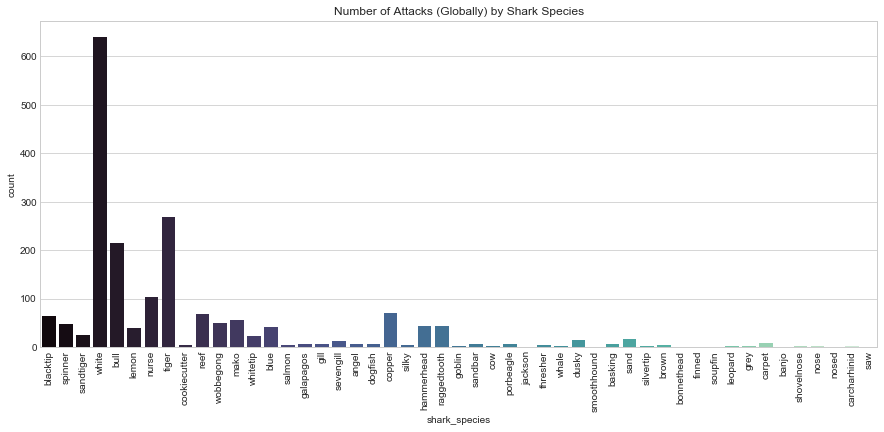

In [38]:
plt.style.use('seaborn-whitegrid')
sharks = ts_gsaf[ts_gsaf.shark_species != 'None Found']
fig = plt.figure(figsize=(15,6))
sns.countplot(sharks.shark_species, palette='mako')
plt.title('Number of Attacks (Globally) by Shark Species')
plt.xticks(rotation=90)
plt.show()

In [35]:
sharks['count'] = [1] * len(sharks)
ts_sharks = sharks.set_index(sharks.datetime)
ts_sharks = ts_sharks[['Type', 'Fatal (Y/N)', 'count']]
ts_sharks.head()

,Type,Fatal (Y/N),count
datetime,,,
2019-07-30,Provoked,N,1
2019-07-27,Unprovoked,N,1
2019-07-22,Unprovoked,N,1
2019-07-17,Unprovoked,N,1
2019-07-10,Unprovoked,N,1


In [36]:
yearly = ts_sharks.resample('A').sum()
yearly.columns = ['Number of Attacks']

ts_provoked = ts_sharks[ts_sharks.Type=='Provoked'].resample('A').sum()
ts_unprovoked = ts_sharks[ts_sharks.Type=='Unprovoked'].resample('A').sum()
ts_otherType = ts_sharks[(ts_sharks.Type !='Provoked') & (ts_sharks.Type !='Unprovoked')].resample('A').sum()

ts_unprovoked.columns = ['Unprovoked']
ts_provoked.columns = ['Provoked']
ts_otherType. columns = ['Other']

ts_attack_type = pd.concat([ts_provoked, ts_unprovoked, ts_otherType], axis=1)

ts_fatal = ts_sharks[ts_sharks['Fatal (Y/N)'] == 'Y'].resample('A').sum()
ts_nonfatal = ts_sharks[ts_sharks['Fatal (Y/N)'] == 'N'].resample('A').sum()

ts_fatal.columns = ['Fatal']
ts_nonfatal.columns = ['Nonfatal']

ts_fatality = pd.concat([ts_fatal, ts_nonfatal], axis=1)

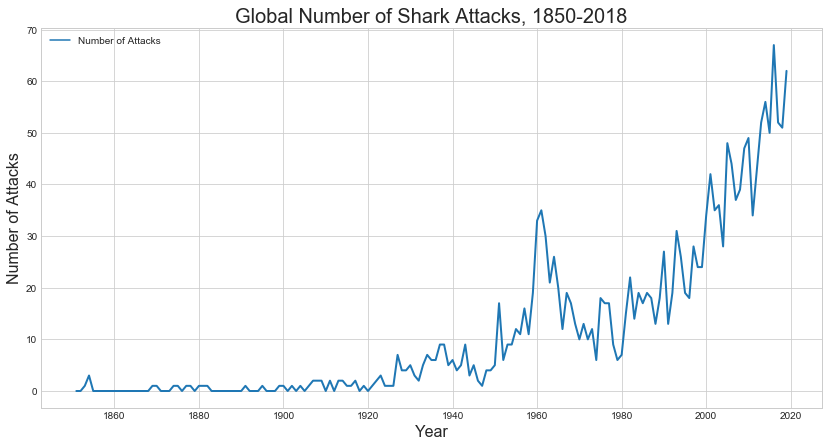

In [39]:

fig = plt.figure(figsize=(14,7))
sns.lineplot(data=yearly['1850':'2018'], lw=2)
plt.title('Global Number of Shark Attacks, 1850-2018', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Attacks', fontsize=16)
plt.show()

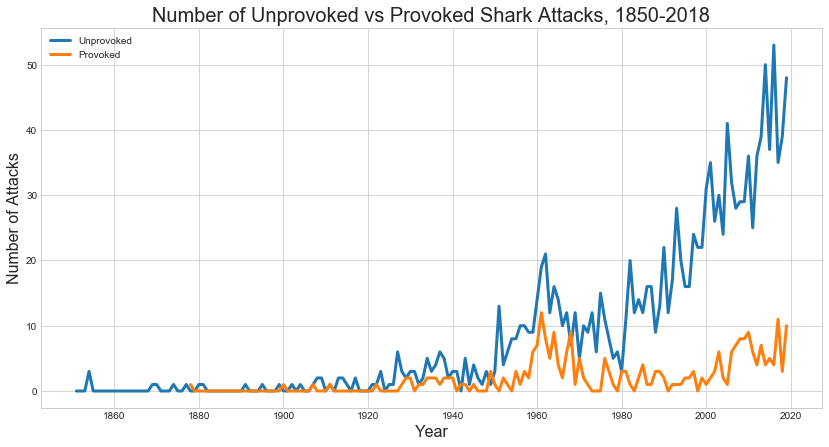

In [40]:

fig = plt.figure(figsize=(14,7))

plt.plot(ts_unprovoked['Unprovoked']['1850':'2018'], lw=3, label='Unprovoked')
plt.plot(ts_provoked['Provoked']['1850':'2018'], lw=3, label='Provoked')

#plt.plot(ts_otherType['Other'], lw=3, label='Other', color='red')
plt.title('Number of Unprovoked vs Provoked Shark Attacks, 1850-2018', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Attacks', fontsize=16)
plt.legend()
plt.show()

In [41]:
ts_attack_type = ts_attack_type.fillna(0)

def ts_percentage(ts1, ts2):
    return ts2 / (ts1 + ts2)

ts_attack_type['perc_unprovoked'] = ts_percentage(ts_attack_type.Provoked, ts_attack_type.Unprovoked)

print(f"Unprovoked attacks average {round(np.mean(ts_attack_type.perc_unprovoked)*100,2)} percent of the total number of attacks each year.")


Unprovoked attacks average 82.95 percent of the total number of attacks each year.


In [408]:
# fig = plt.figure(figsize=(15,7))
# ts_attack_type.perc_unprovoked['1940':'2018'].plot(kind='area', color='teal')

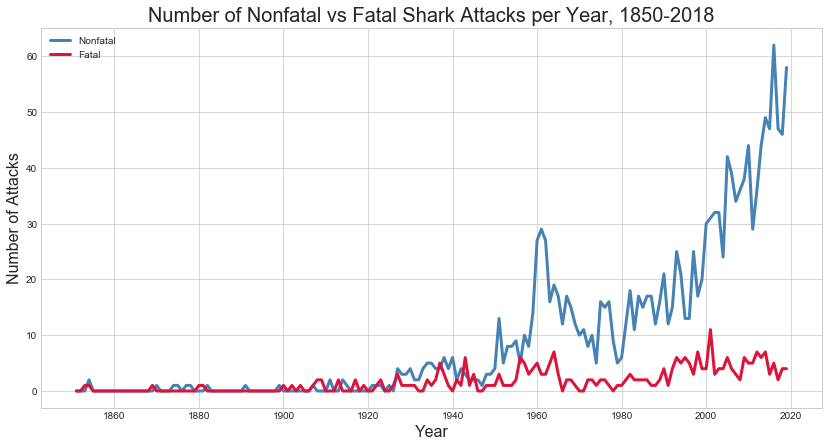

In [42]:
fig = plt.figure(figsize=(14,7))

plt.plot(ts_nonfatal['1850':'2018'], lw=3, label='Nonfatal', color='steelblue')
plt.plot(ts_fatal['1850':'2018'], lw=3, label='Fatal', color='crimson')

#plt.plot(ts_otherType['Other'], lw=3, label='Other', color='red')
plt.title('Number of Nonfatal vs Fatal Shark Attacks per Year, 1850-2018', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Attacks', fontsize=16)
plt.legend()
plt.show()

In [43]:
ts_fatality['perc_fatal'] = ts_percentage(ts_fatality.Nonfatal, ts_fatality.Fatal)

print(f"Fatal attacks average {round(np.mean(ts_fatality.perc_fatal)*100,2)} percent of the total number of attacks each year.")
print(f"However, over the past 50 years fatal shark attacks only average {round(np.mean(ts_fatality['1968':].perc_fatal)*100,2)} of the total number of attacks each year.")



Fatal attacks average 27.42 percent of the total number of attacks each year.
However, over the past 50 years fatal shark attacks only average 12.54 of the total number of attacks each year.


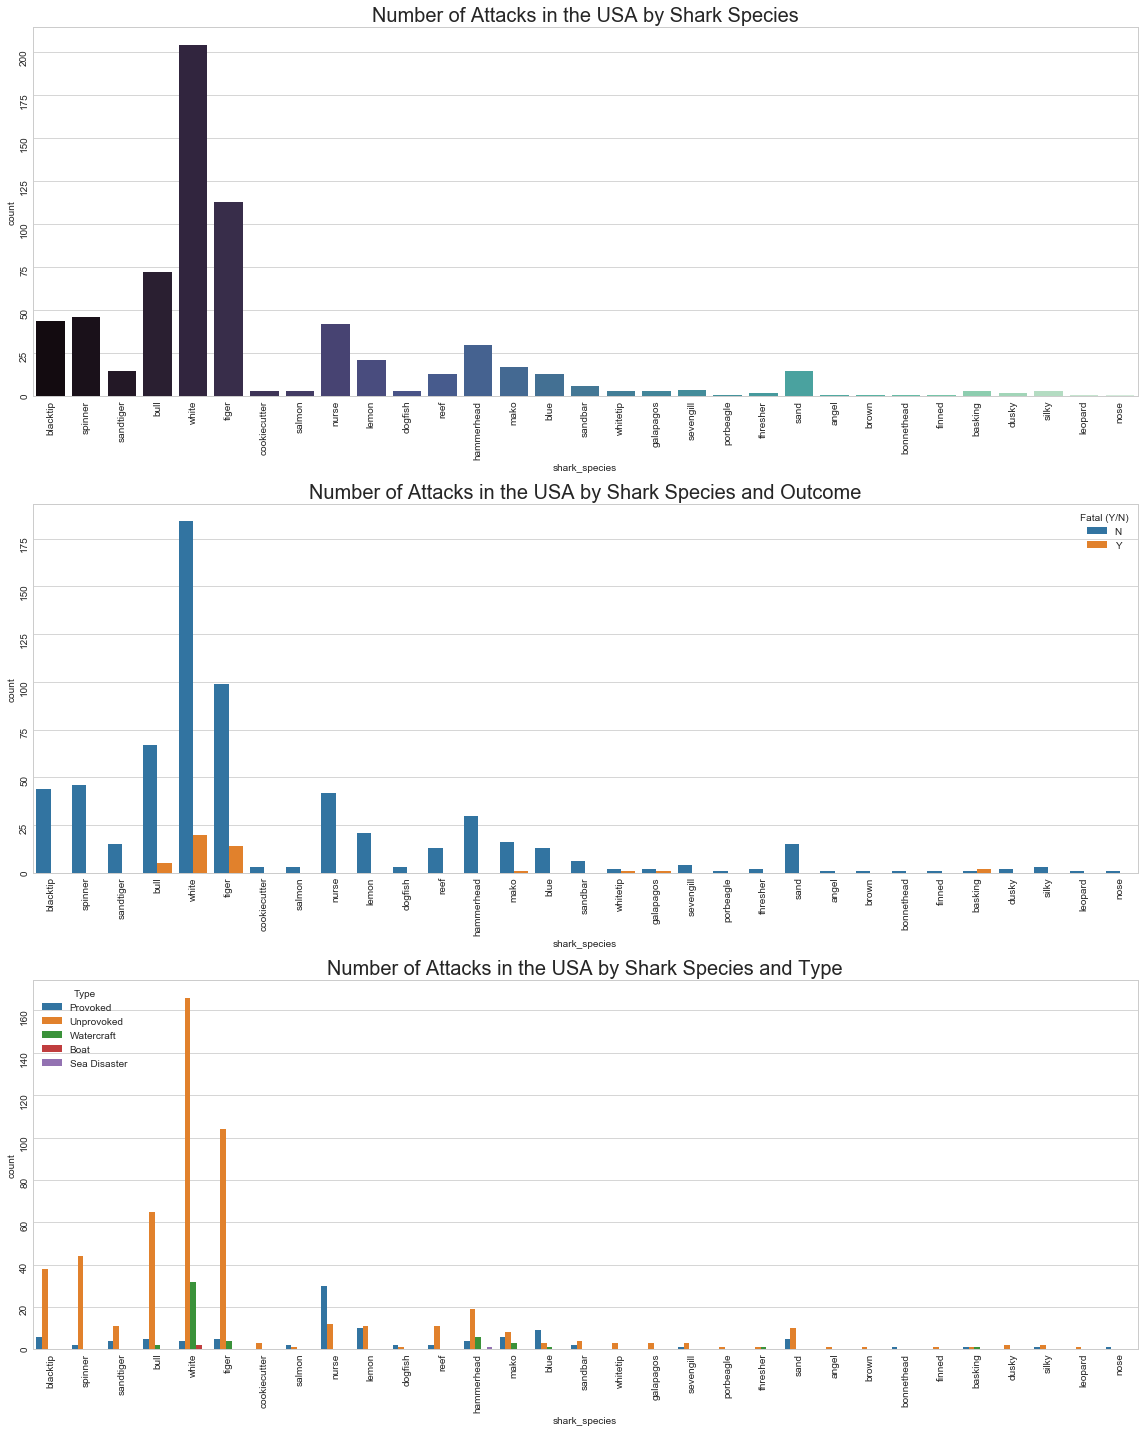

In [44]:
usa_sharks = sharks[(sharks.Country == 'USA') & (sharks.Type != 'Questionable') & (sharks.Type != 'Invalid') & 
                   (sharks['Fatal (Y/N)'] != 'UNKNOWN')]
fig, ax = plt.subplots(3,1,figsize=(16,20))

sns.countplot(x='shark_species', data=usa_sharks, palette='mako', ax=ax[0])
ax[0].set_title('Number of Attacks in the USA by Shark Species', fontsize=20)
ax[0].tick_params(labelrotation=90)

sns.countplot(x='shark_species', data=usa_sharks, hue='Fatal (Y/N)', ax=ax[1])
ax[1].set_title('Number of Attacks in the USA by Shark Species and Outcome', fontsize=20)
ax[1].tick_params(labelrotation=90)

sns.countplot(x='shark_species', data=usa_sharks, hue='Type', ax=ax[2])
ax[2].set_title('Number of Attacks in the USA by Shark Species and Type', fontsize=20)
ax[2].tick_params(labelrotation=90)

plt.tight_layout()

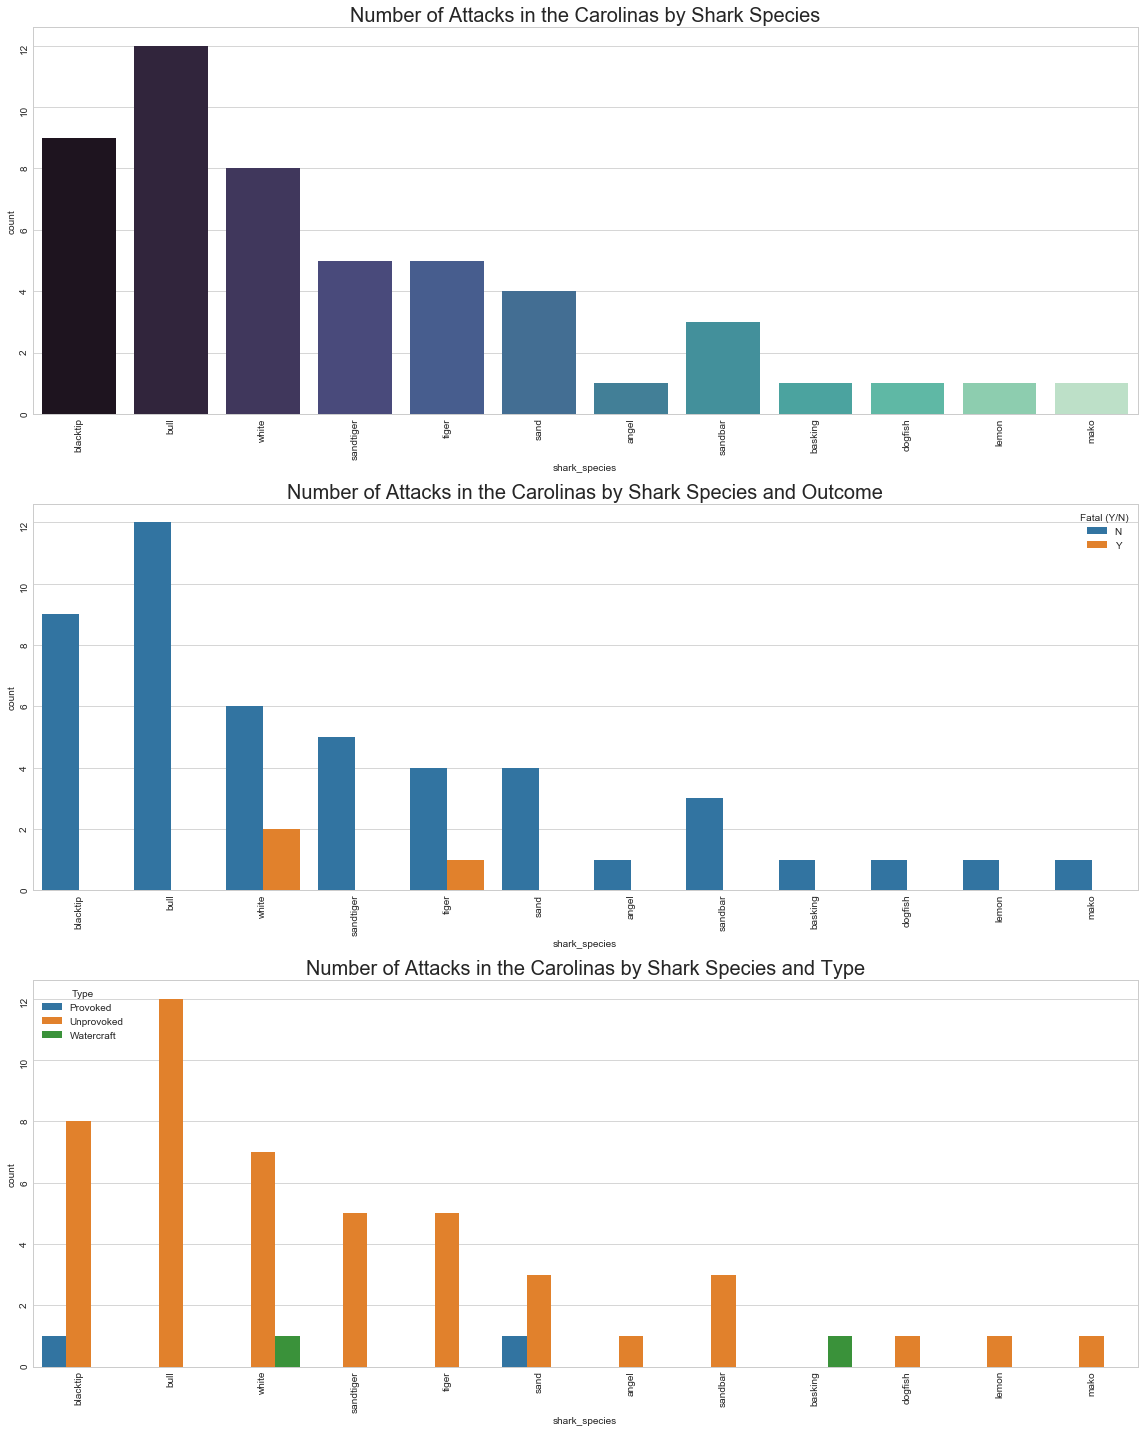

In [45]:
carolina_sharks = usa_sharks[(usa_sharks.Area == 'North Carolina') | (usa_sharks.Area == 'South Carolina')]

fig, ax = plt.subplots(3,1,figsize=(16,20))

sns.countplot(x='shark_species', data=carolina_sharks, palette='mako', ax=ax[0])
ax[0].set_title('Number of Attacks in the Carolinas by Shark Species', fontsize=20)
ax[0].tick_params(labelrotation=90)

sns.countplot(x='shark_species', data=carolina_sharks, hue='Fatal (Y/N)', ax=ax[1])
ax[1].set_title('Number of Attacks in the Carolinas by Shark Species and Outcome', fontsize=20)
ax[1].tick_params(labelrotation=90)

sns.countplot(x='shark_species', data=carolina_sharks, hue='Type', ax=ax[2])
ax[2].set_title('Number of Attacks in the Carolinas by Shark Species and Type', fontsize=20)
ax[2].tick_params(labelrotation=90)

plt.tight_layout()


## Shark Attack Data for Carolina Region of the USA

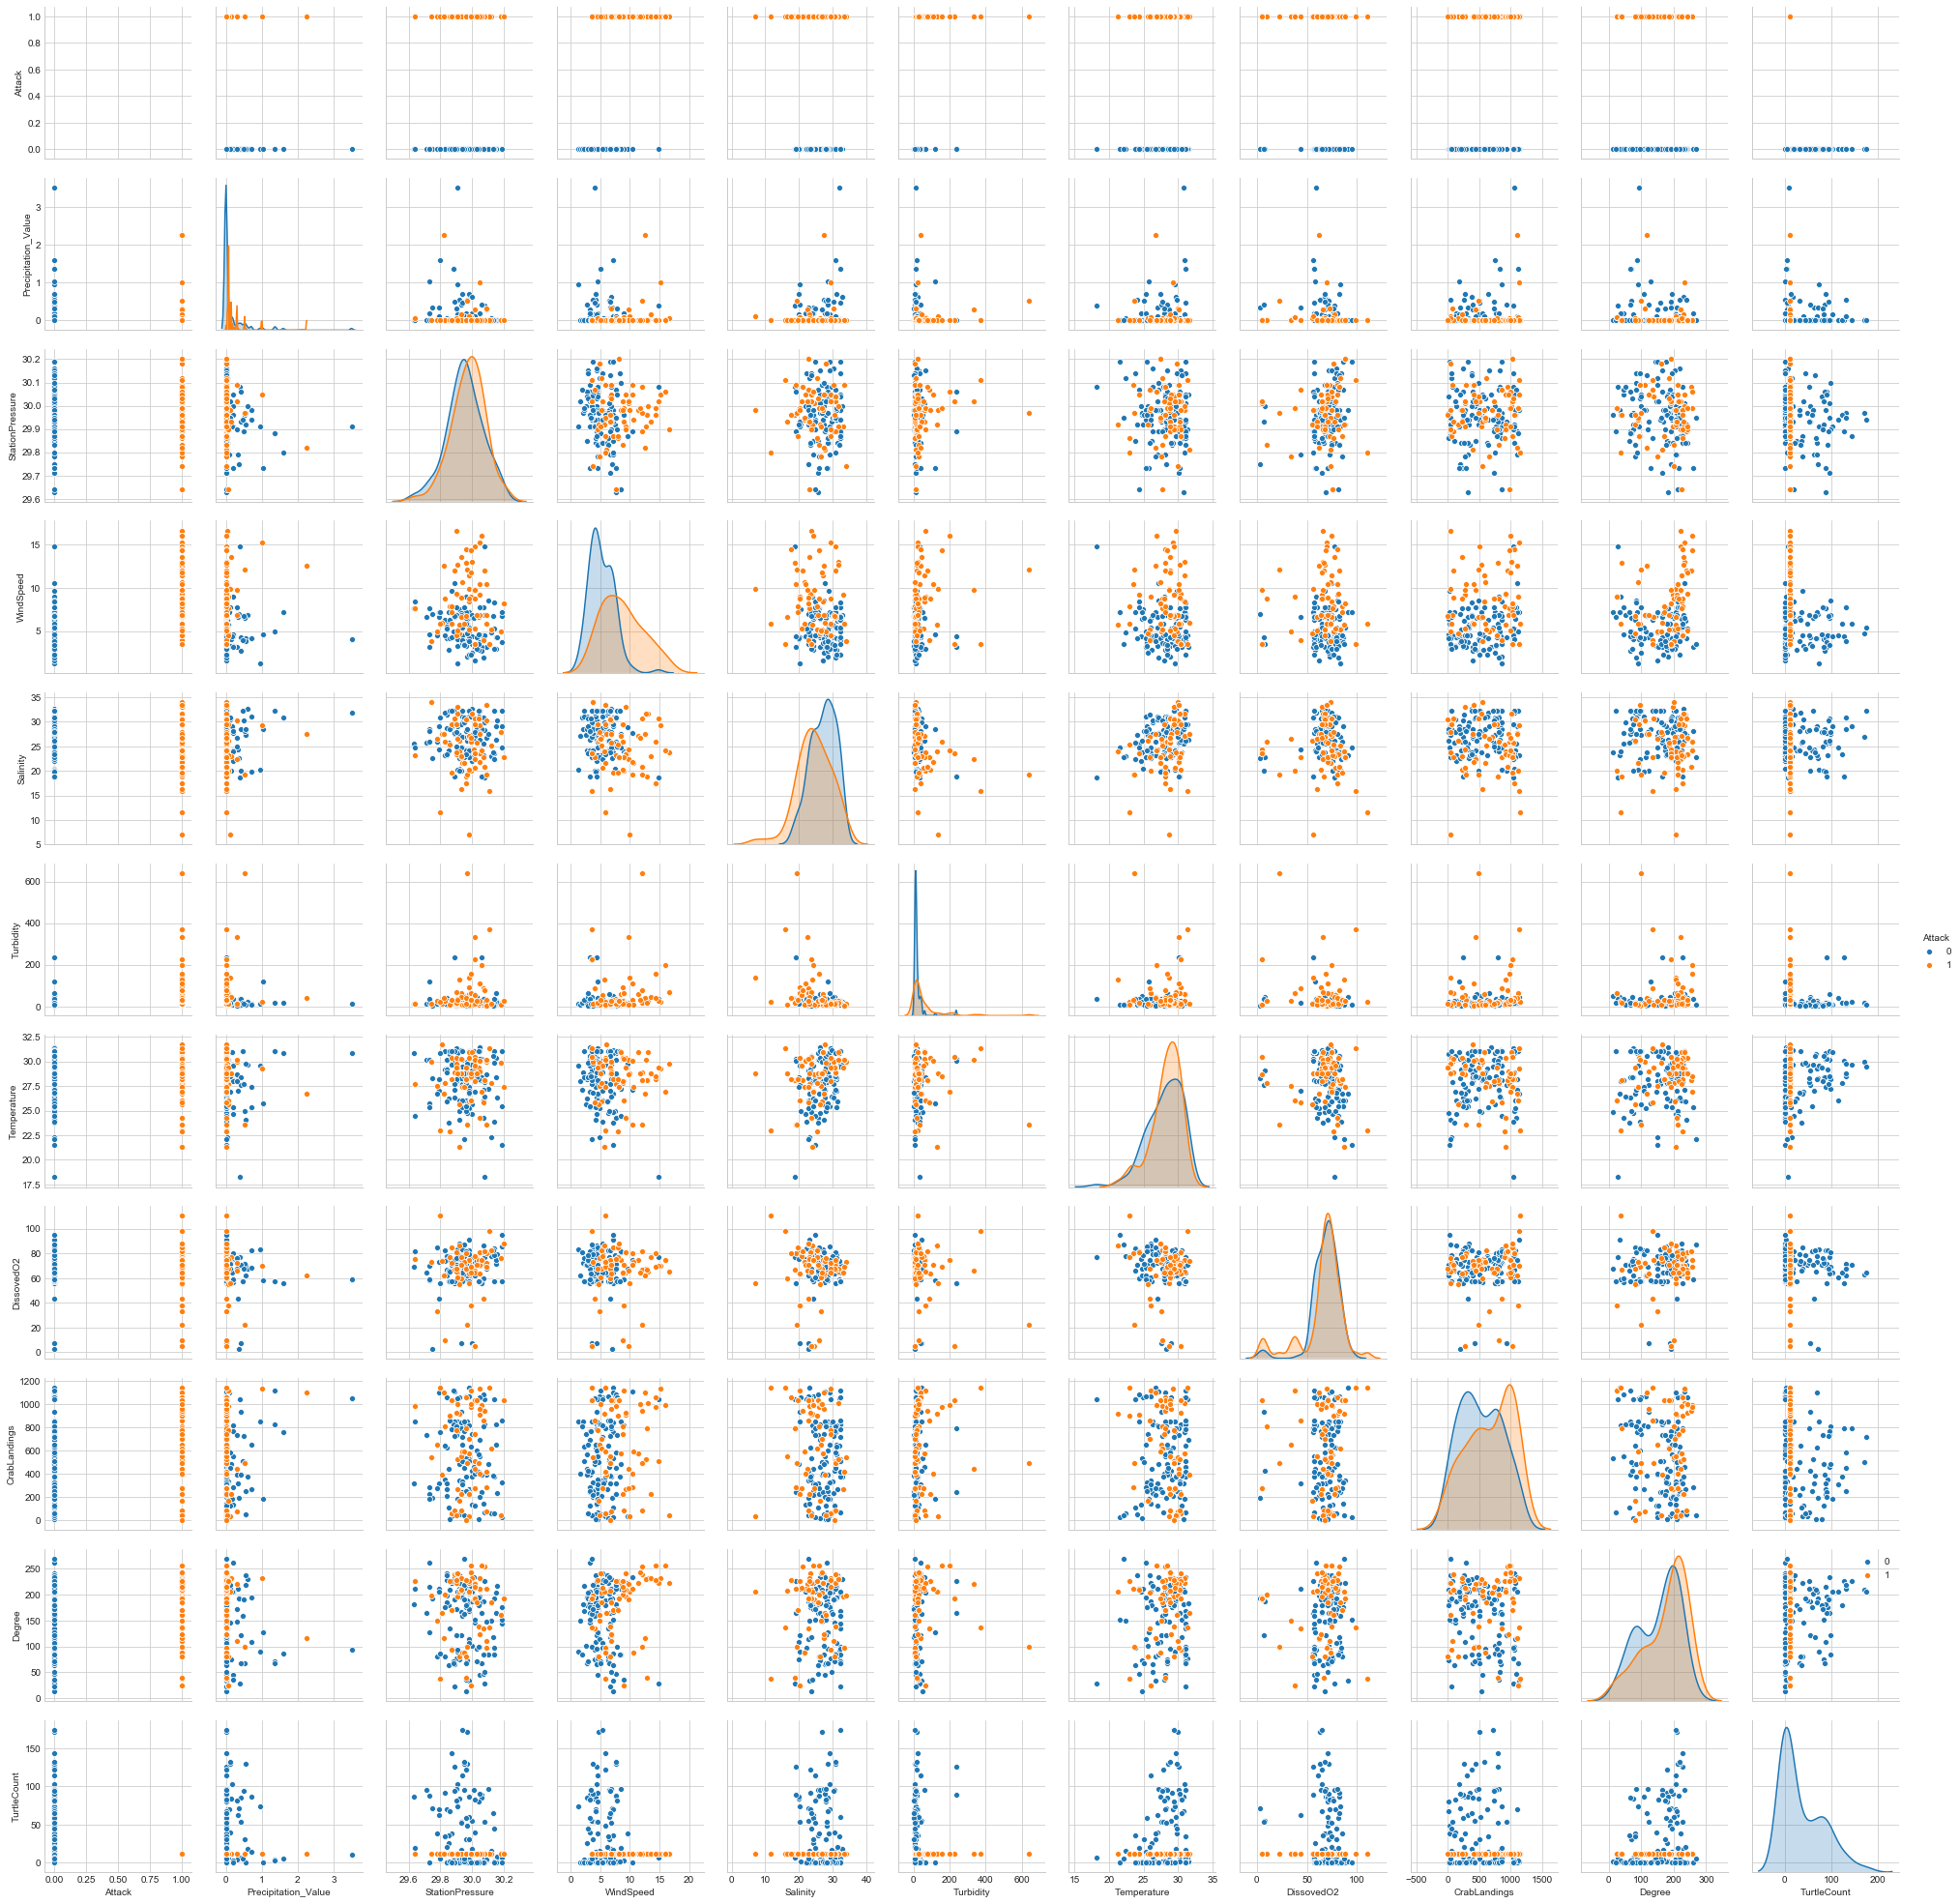

In [46]:
# Look for correlation with continuous variables
sns.pairplot(model_df, hue='Attack')
plt.legend()
plt.show()

**Analysis:** Looking at the distribution plots that run along the diagonal of the scatterplot matrix, it does appear that shark attacks happen more frequently when wind speed and number of crab landings are higher and when salinity is lower. Additionally there doesn't appear to be strong evidence of correlation between the features (multicolinearity), but this will examined further with a heatmap in the next cell. Lastly, the plot in the bottom right corner of the figure is odd as it suggests that shark attacks did not occur on days that a turtle count was recorded. This will also be examined further.

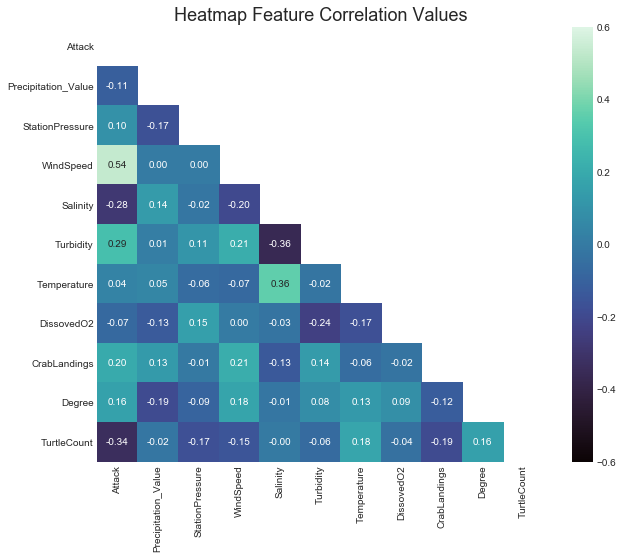

In [47]:
# Another check for correlation and multicollinearity
mask = np.zeros_like(model_df.corr())
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(10,8))
sns.heatmap(model_df.corr(), vmin=-.6, vmax=.6, mask=mask, cmap='mako', annot=True, fmt='.2f')
plt.title('Heatmap Feature Correlation Values', fontsize=18)
plt.show()

**Analysis:** Several features display moderate levels of correlation with the frequency of shark attacks. Wind speed shows the strongest positive correlation (0.5) with attacks, while salinity shows the strongest negative correlation (-0.3). These findings are in line with the conclusions drawn from the pairplot above. While it was difficult to determine from the pairplot, turbidity also shows a moderate positive correlation (0.3) with attacks when analyzed using this heatmap. Additionally, there does not appear to be strong evidence of multicolinearity as the strongest within-feature correlations are -0.4 (turbidity-salinity) and 0.4 (temperature-salinity). No action needs to be taken at this time to address multicolinearity as these interactions are moderate at best.

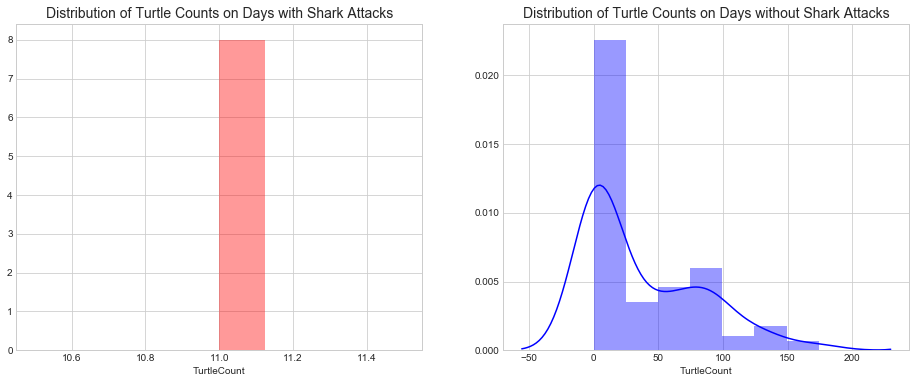

In [48]:
attacks = model_df[model_df.Attack == 1]
no_attacks = model_df[model_df.Attack == 0]

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(attacks.TurtleCount, color='red', ax=ax[0])
ax[0].set_title('Distribution of Turtle Counts on Days with Shark Attacks', fontsize=14)
sns.distplot(no_attacks.TurtleCount, color='blue', ax=ax[1])
ax[1].set_title('Distribution of Turtle Counts on Days without Shark Attacks', fontsize=14)
plt.show()

In [369]:
attacks.TurtleCount.value_counts()

11.0    68
Name: TurtleCount, dtype: int64

All of the turtle counts on the days that had shark attacks are equal to eleven, the median value of the column and the value that was used to impute Null values. For this reason, no strong conclusions from the TurtleCount data can be made as all of the data is imputed and will be dropped from dataset for modeling. 

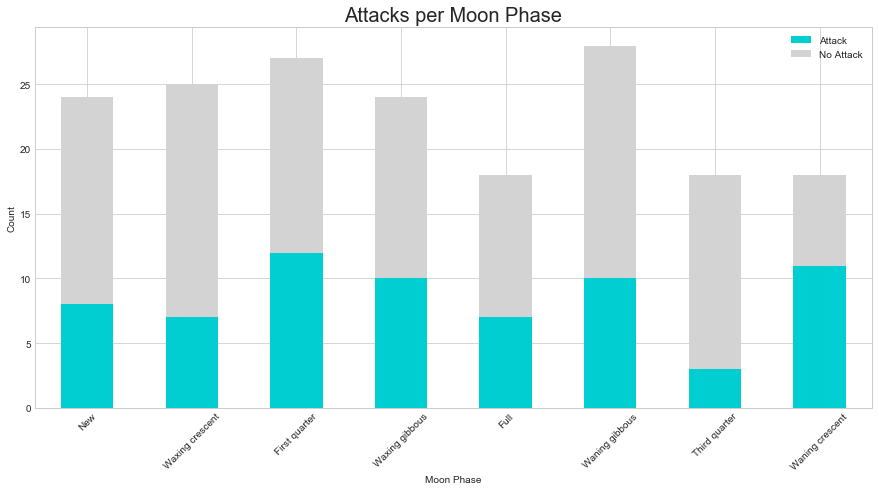

In [49]:
# plt.style.use('seaborn-whitegrid')
# Look for trend in categorical variable - MoonPhase



moonphase = ['New', 'Waxing crescent', 'First quarter', 'Waxing gibbous', 'Full', 'Waning gibbous', 'Third quarter', 
            'Waning crescent']

moon_total = []
moon_attack = []
for phase in moonphase:
    total_phase = len(model_df[model_df.MoonPhase == phase])
    attack_phase = len(attacks[attacks.MoonPhase == phase])
    moon_attack.append(attack_phase)
    moon_total.append(total_phase-attack_phase)
        
moon_freq_df = pd.DataFrame(np.array([moon_attack, moon_total]))
moon_freq_df.columns = moonphase
moon_freq_df.index = ['Attack', 'No Attack']


moon_freq_df.T.plot(kind='bar', stacked=True, colors=['darkturquoise', 'lightgrey'], figsize=(15,7))
plt.title('Attacks per Moon Phase', fontsize=20)
plt.xlabel('Moon Phase')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

The phase of the moon does not appear to have an effect on shark attack frequency as there seems to be a relatively equal distribution of attacks for each phase. Combining these finding with the time of the attack may provide more information as phases where more of the moon's surface are illuminated may make night time attacks more frequent. Attacks during dawn, dusk, and night time hours should be more frequent anyways as these are the times that most sharks feed ([Source](https://www.sharks-world.com/shark-behavior/)), but fewer people may be in the water at those times. However, the greater reflection of light off of the moon may make objects in the water close to the surface more visible during low-light times of day.

In [50]:
attack_dark = data2[(data2.Timeofattack == 'Dusk') | 
                    (data2.Timeofattack == 'Dawn') | 
                    (data2.Timeofattack == 'Evening')]

attack_light = data2[data2.Timeofattack == 'Day']

print('Dark: ', attack_dark.shape[0])
print('Light: ', attack_light.shape[0])

Dark:  25
Light:  39


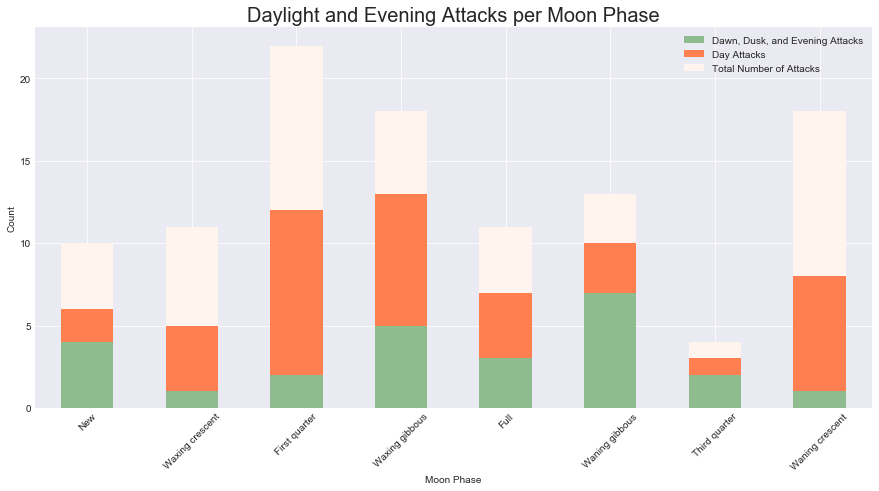

In [51]:
plt.style.use('seaborn-darkgrid')
moonphase = ['New', 'Waxing crescent', 'First quarter', 'Waxing gibbous', 'Full', 'Waning gibbous', 'Third quarter', 
            'Waning crescent']

moon_total = []
moon_attack = []
moon_day = []
for phase in moonphase:
    total_phase = len(attacks[attacks.MoonPhase == phase])
    attack_phase = len(attack_dark[attack_dark.MoonPhase == phase])
    day_attack = len(attack_light[attack_light.MoonPhase == phase])
    moon_attack.append(attack_phase)
    moon_total.append(total_phase-attack_phase)
    moon_day.append(day_attack)
        
moon_freq_df = pd.DataFrame(np.array([moon_attack, moon_day, moon_total]))
moon_freq_df.columns = moonphase
# moon_freq_df.index = ['Attack', 'No Attack']


moon_freq_df.T.plot(kind='bar', stacked=True, colors=['darkseagreen', 'coral', 'seashell'], figsize=(15,7)) 
plt.title('Daylight and Evening Attacks per Moon Phase', fontsize=20)
plt.xlabel('Moon Phase')
plt.xticks(rotation=45)
plt.ylabel('Count')
L = plt.legend()
L.get_texts()[2].set_text("Total Number of Attacks")
L.get_texts()[0].set_text("Dawn, Dusk, and Evening Attacks")
L.get_texts()[1].set_text("Day Attacks")
plt.show()

In [243]:
# def confirm_species(shark_list, species_list):
#     confirm_shark = []
    
#     iter_sharks = iter(shark_list)
#     shark = next(iter_sharks)
#     print(f"Current shark: {shark}")
    
#     for j in species_list:
#         if shark == 'None Found':
#             confirm_shark.append(shark)
#             shark = next(iter_sharks)
#             print(f"Current shark: {shark}")
#         elif shark == 'white':
#             confirm_shark.append(shark)
#             shark = next(iter_sharks)
#             print(f"Current shark: {shark}")
#         elif shark == 'saw':
#             confirm_shark.append(shark)
#             break
#         for i in list(range(0,len(species_list))):
#             if shark in species_list[i]:
#                 print(f"MATCH: {shark} and {species_list[i]}")
#                 confirm_shark.append(shark)
#                 shark = next(iter_sharks)
#                 print(f"Current shark: {shark}")
#             elif species_list[i] == 'leopard shark':
#                 #print(f"No match for {shark} and {species_list[i]}")
#                 shark = next(iter_sharks)
#                 print(f"Current shark: {shark}")
#             else:
#                 continue

#     return confirm_shark

To analyze which species of shark has the highest frequency of attacks, regex expressions will need to be used to parse through the unstructured strings in the ```Species``` column.

regex word before a word

\w+(?=\s+shark|\s+Shark)

In [131]:
# def regex_finder(expression, text):
#     pattern = expression
#     p = re.compile(pattern)
#     result = p.findall(text)
#     return result

In [376]:
# species = []
# for txt in attacks2.Species:  
    
#     shark = regex_finder('\w+(?=\s+shark|\s+Shark)', txt)
    
#     if len(shark) > 0:
#         shark_fin = max(set(shark), key=shark.count)
#         species.append(shark_fin.lower())
#     else:
#         species.append('None')
        
    

    
# attacks2['shark_species'] = species
# attacks2.head()

In [377]:
# attacks2.shark_species.value_counts()

In [378]:
# sharks_df = attacks2[(attacks2.shark_species == 'bull') | (attacks2.shark_species == 'blacktip') | 
#          (attacks2.shark_species == 'sandtiger') | (attacks2.shark_species == 'lemon') |
#         (attacks2.shark_species == 'tiger') | (attacks2.shark_species == 'mako')]
# sharks_df

In [379]:
# fig = plt.figure(figsize=(10,6))
# sns.countplot(sharks_df.shark_species, color='teal')
# plt.title('Number of Shark Attacks per Species')
# plt.show()

# Modeling

The goal of this section will be to determine which machine learning model performs the best at predicting shark attacks. The evaluation metrics used to determine which model is "best" will be based on: accuracy, F1 score, and ROC-AUC measures. The models tested will be: naive bayes, logistic regression, random forest, adaboost, gradient boosting. k-nearest, svc, and xgboost.

In [10]:
# Isolate target and features
y = model_df.Attack
x1 = model_df.drop(['Attack', 'Date'], axis=1)
x2 = model_df.drop(['Attack', 'MoonPhase', 'Date', 'TurtleCount'], axis=1) # Consider binning CrabLandings

In [11]:
x2.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree
0,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556
1,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222
2,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111
3,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778
4,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222


In [12]:
# Import packages for preprocessing data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Scale the features with MinMax to bring all values in the range [0,1]
min_max = MinMaxScaler()

minmax_x = pd.DataFrame(min_max.fit_transform(x2), columns=x2.columns)
minmax_x.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree
0,0.000000,0.578947,0.333333,0.636021,0.032566,0.576733,0.741354,0.933566,0.819105
1,0.054286,0.649123,0.202614,0.552312,0.037936,0.477558,0.675088,0.114510,0.752212
2,0.000000,0.508772,0.405229,0.496314,0.027615,0.498185,0.703665,0.925699,0.775204
3,0.000000,0.508772,0.267974,0.579198,0.020119,0.575743,0.788776,0.296329,0.817630
4,0.000000,0.614035,0.385621,0.597837,0.066004,0.627393,0.822323,0.994755,0.079906


In [14]:
# Encode the categorical variables with labels
labeler = LabelEncoder()

labeled_moon = pd.Series(labeler.fit_transform(x1['MoonPhase']), name='MoonPhase', dtype='category')

final_x = pd.concat([minmax_x, labeled_moon], axis=1)
final_x.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree,MoonPhase
0,0.000000,0.578947,0.333333,0.636021,0.032566,0.576733,0.741354,0.933566,0.819105,0
1,0.054286,0.649123,0.202614,0.552312,0.037936,0.477558,0.675088,0.114510,0.752212,0
2,0.000000,0.508772,0.405229,0.496314,0.027615,0.498185,0.703665,0.925699,0.775204,7
3,0.000000,0.508772,0.267974,0.579198,0.020119,0.575743,0.788776,0.296329,0.817630,7
4,0.000000,0.614035,0.385621,0.597837,0.066004,0.627393,0.822323,0.994755,0.079906,1


In [15]:
final_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 10 columns):
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           182 non-null float64
Degree                 182 non-null float64
MoonPhase              182 non-null category
dtypes: category(1), float64(9)
memory usage: 13.4 KB


In [16]:
# Import modeling and evaluation packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

In [17]:
def model_assessment(model, n):
    """
    Function to calculate accuracy, f1-score, and AUC eval metrics for an SciKit Learn model over a specified number 
    of iterations.
    
    Input:
    model - tupel in the form of (instantiated_model_variable, alias_string)
    n - the number of times to run the model; integer
    
    Return:
    pandas dataframe containing eval metrics from the training and testing sets over n iterations
    
    """
    
    # Create empty lists to house eval metrics
    acc_train = []
    acc_test = []
    f1_train = []
    f1_test = []
    roc_auc_train = []
    roc_auc_test = []
    
    # isolate the string alias of the model
    model_name = model[1]
    
    # fit the model n number of times and record eval metrics for each iteration
    for i in range(n):
        
        # split the data into train and test sets. DO NOT set random seed to allow for variability
        X_train, X_test, y_train, y_test = train_test_split(final_x, y, test_size=0.2)
        
        # fit the model and generate predictions for the train and test sets
        model[0].fit(X_train, y_train)
        train_preds = model[0].predict(X_train)
        test_preds = model[0].predict(X_test)
        
        # calculate accuracy scores for train and test sets
        train_acc = accuracy_score(y_train, train_preds)
        acc_train.append(train_acc)
        test_acc = accuracy_score(y_test, test_preds)
        acc_test.append(test_acc)
        
        # calculate f1-scores for train and test sets
        train_f1 = f1_score(y_train, train_preds)
        f1_train.append(train_f1)
        test_f1 = f1_score(y_test, test_preds)
        f1_test.append(test_f1)
        
        # calculate auc for train and test sets
        train_roc_auc = roc_auc_score(y_train, train_preds)
        roc_auc_train.append(train_roc_auc)
        test_roc_auc = roc_auc_score(y_test, test_preds)
        roc_auc_test.append(test_roc_auc)
    
    # return df with eval metrics for all iterations
    return pd.DataFrame(np.array([acc_train, acc_test, f1_train, f1_test, roc_auc_train, roc_auc_test]).T, 
                        columns=[model_name+'_Training_Acc',model_name+'_Testing_Acc',model_name+'_Training_F1', 
                                 model_name+'_Testing_F1', model_name+'_Training_AUC', model_name+'_Testing_AUC'])

In [18]:
# Instantiate models
naive_bayes = GaussianNB()
logistic = LogisticRegression()
random_forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
gradient_boost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
svc = SVC()

# Create list of models and name alias
models = [(naive_bayes, 'naive_bayes'), (logistic, 'logistic'), (random_forest, 'random_forest'), 
          (adaboost, 'adaboost'), (gradient_boost, 'gradient_boost'), (knn, 'knn'), (svc, 'svc')]

In [22]:
# Iterate through the list of models and combine dfs to get single baseline df
df = []
for mod in models:
    df.append(model_assessment(mod, 1000)) # perform 1000 iterations
    
baseline_df = pd.concat(df, axis=1)
baseline_df.head()

,naive_bayes_Training_Acc,naive_bayes_Testing_Acc,naive_bayes_Training_F1,naive_bayes_Testing_F1,naive_bayes_Training_AUC,naive_bayes_Testing_AUC,logistic_Training_Acc,logistic_Testing_Acc,logistic_Training_F1,logistic_Testing_F1,...,knn_Training_F1,knn_Testing_F1,knn_Training_AUC,knn_Testing_AUC,svc_Training_Acc,svc_Testing_Acc,svc_Training_F1,svc_Testing_F1,svc_Training_AUC,svc_Testing_AUC
0,0.793103,0.864865,0.659091,0.814815,0.741212,0.843750,0.820690,0.756757,0.704545,0.571429,...,0.575000,0.434783,0.693575,0.622059,0.662069,0.594595,0.140351,0.000000,0.537736,0.500000
1,0.827586,0.756757,0.736842,0.571429,0.791107,0.692547,0.820690,0.864865,0.704545,0.800000,...,0.637363,0.285714,0.725083,0.546131,0.675862,0.702703,0.318841,0.153846,0.594828,0.512963
2,0.800000,0.837838,0.674157,0.769231,0.750410,0.810606,0.813793,0.810811,0.689655,0.695652,...,0.644444,0.444444,0.730057,0.562112,0.662069,0.540541,0.075472,0.000000,0.519608,0.500000
3,0.813793,0.783784,0.703297,0.666667,0.768824,0.742236,0.834483,0.648649,0.714286,0.518519,...,0.681319,0.480000,0.754040,0.605769,0.655172,0.702703,0.218750,0.000000,0.561404,0.500000
4,0.813793,0.810811,0.689655,0.758621,0.762203,0.798529,0.800000,0.837838,0.623377,0.812500,...,0.626506,0.518519,0.723158,0.641813,0.668966,0.729730,0.314286,0.000000,0.589080,0.500000


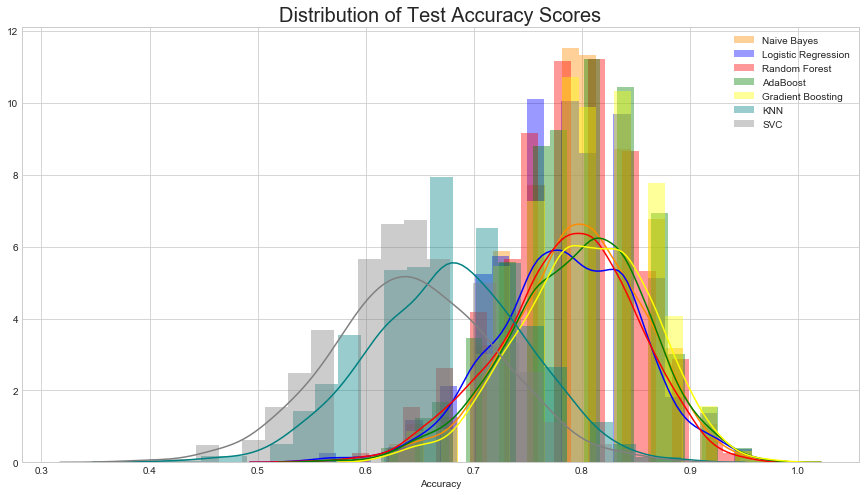

In [59]:
# Plot distribution of accuracy scores for each model evaluated on the testing set
plt.style.use('seaborn-whitegrid')

from scipy.stats import norm

fig = plt.figure(figsize=(15,8))

sns.distplot(baseline_df['naive_bayes_Testing_Acc'], color='darkorange', label='Naive Bayes')
sns.distplot(baseline_df['logistic_Testing_Acc'], color='blue', label='Logistic Regression')
sns.distplot(baseline_df['random_forest_Testing_Acc'], color='red', label='Random Forest')
sns.distplot(baseline_df['adaboost_Testing_Acc'], color='green', label='AdaBoost')
sns.distplot(baseline_df['gradient_boost_Testing_Acc'], color='yellow', label='Gradient Boosting')
sns.distplot(baseline_df['knn_Testing_Acc'], color='teal', label='KNN')
sns.distplot(baseline_df['svc_Testing_Acc'], color='grey', label='SVC')
plt.xlabel('Accuracy')
plt.title('Distribution of Test Accuracy Scores', fontsize=20)
plt.legend()
plt.show()

**Analysis:** The distribution of accuracy scores for the models evaluated on the testing set indicate that the KNN and SVC models performed the worst as their distributions are shifted to the left of the other distributions. The other five distributions (naive bayes, logistic regression, random forest, adaboost, and gradient boosting) are clustered relatively tightly, but the ditribution for gradient boosting does appear to be shifted the furthest right, indicating its accuracy scores were the highest.

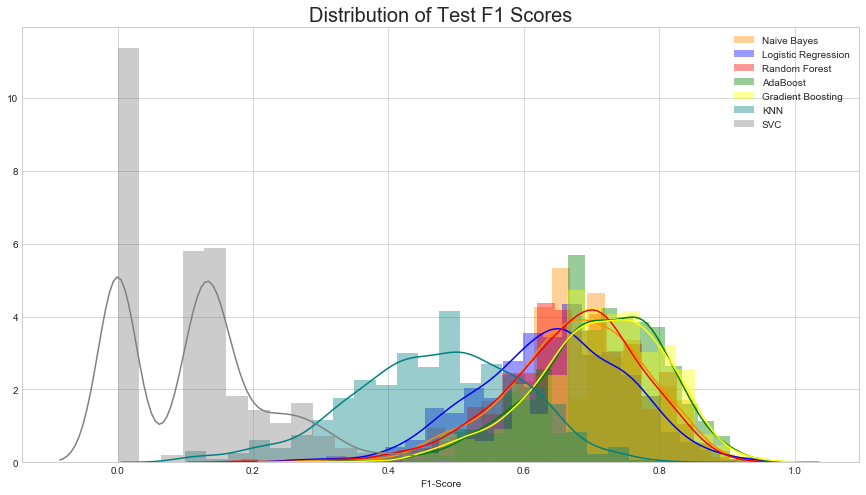

In [56]:
# Plot distribution of f1-scores for each model evaluated on the testing set

fig = plt.figure(figsize=(15,8))

sns.distplot(baseline_df['naive_bayes_Testing_F1'], color='darkorange', label='Naive Bayes')
sns.distplot(baseline_df['logistic_Testing_F1'], color='blue', label='Logistic Regression')
sns.distplot(baseline_df['random_forest_Testing_F1'], color='red', label='Random Forest')
sns.distplot(baseline_df['adaboost_Testing_F1'], color='green', label='AdaBoost')
sns.distplot(baseline_df['gradient_boost_Testing_F1'], color='yellow', label='Gradient Boosting')
sns.distplot(baseline_df['knn_Testing_F1'], color='teal', label='KNN')
sns.distplot(baseline_df['svc_Testing_F1'], color='grey', label='SVC')
plt.xlabel('F1-Score')
plt.title('Distribution of Test F1 Scores', fontsize=20)
plt.legend()
plt.show()

**Analysis:** A model's F1-Score is indicative of its overall performance as high precision and recall scores are needed for a high F1-Score. The positions of the distributions again suggest that the KNN and SVC models performed the worst on the classification task as their distributions are the fursthest to the left. Again the other five distributions are clustered together with means around 0.65, with the distribution for the gradient boosting model located furthest to the right, indicating it produced the strongest F1-Score.

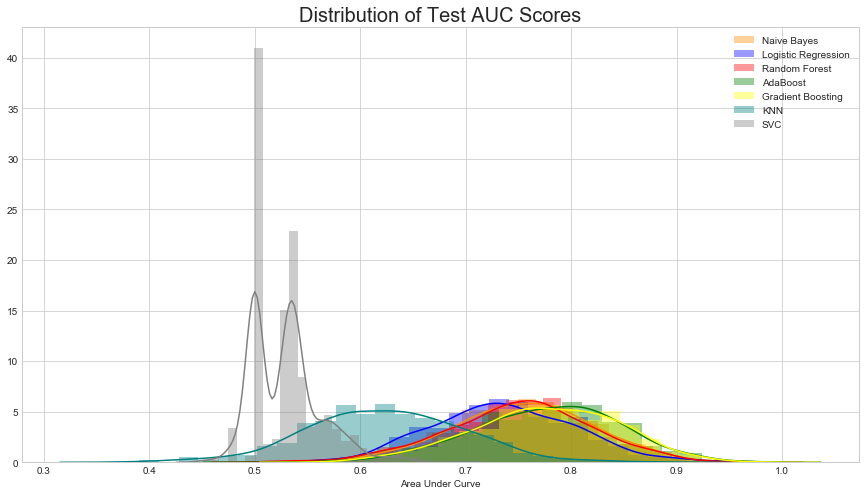

In [55]:
# Plot distribution of AUC scores for each model evaluated on the testing set

fig = plt.figure(figsize=(15,8))

sns.distplot(baseline_df['naive_bayes_Testing_AUC'], color='darkorange', label='Naive Bayes')
sns.distplot(baseline_df['logistic_Testing_AUC'], color='blue', label='Logistic Regression')
sns.distplot(baseline_df['random_forest_Testing_AUC'], color='red', label='Random Forest')
sns.distplot(baseline_df['adaboost_Testing_AUC'], color='green', label='AdaBoost')
sns.distplot(baseline_df['gradient_boost_Testing_AUC'], color='yellow', label='Gradient Boosting')
sns.distplot(baseline_df['knn_Testing_AUC'], color='teal', label='KNN')
sns.distplot(baseline_df['svc_Testing_AUC'], color='grey', label='SVC')
plt.xlabel('Area Under Curve')
plt.title('Distribution of Test AUC Scores', fontsize=20)
plt.legend()
plt.show()

**Analysis:** The AUC evaluation metric is another comprehensive measure of model performance like the F1-Score. The AUC refers to the area under the ROC curve. The ROC curve is a measure of the model's true positive rate versus its true negative rate. In simplest terms, AUC can be thought of as a measure of how well the model separated the two classes in the data. An AUC of 1 means the model classified every data point perfectly, where an AUC of 0.5 is equal to random guessing (in a dataset with balanced classes). Because the target class in this dataset only represents roughly 30% of all the observations, accuracy scores alone could be misleading. Thus, combining accuracy scores with AUC measures should provide a better view of model performance.

Again, KNN and SVC performed the worst as the distributions of their AUC scores are shifted furthest to the left. The distribution for the gradient bosting model appears to be the furthest right, indicating the best AUC measures.

In [28]:
# Compare each model's training and testing eval metrics to assess for overfitting

avg_acc_train = []
avg_f1_train = []
avg_auc_train = []


avg_acc_test = []
avg_f1_test = []
avg_auc_test = []


for model in models:
    name = model[1]
    
    avg_acc_train.append(np.mean(baseline_df[name+'_Training_Acc']))
    avg_f1_train.append(np.mean(baseline_df[name+'_Training_F1']))
    avg_auc_train.append(np.mean(baseline_df[name+'_Training_AUC']))
    
    avg_acc_test.append(np.mean(baseline_df[name+'_Testing_Acc']))
    avg_f1_test.append(np.mean(baseline_df[name+'_Testing_F1']))
    avg_auc_test.append(np.mean(baseline_df[name+'_Testing_AUC']))
    
model_names = [i[1] for i in models]


baseline_avg_train = pd.DataFrame(np.array([avg_acc_train, avg_f1_train, avg_auc_train]).T, 
                                  columns=['accuracy', 'f1_score', 'AUC'], index=model_names)

baseline_avg_train['group'] = ['train'] * 7


baseline_avg_test = pd.DataFrame(np.array([avg_acc_test, avg_f1_test, avg_auc_test]).T, 
                                  columns=['accuracy', 'f1_score', 'AUC'], index=model_names)

baseline_avg_test['group'] = ['test'] * 7


baseline_avg_df = pd.concat([baseline_avg_train, baseline_avg_test], axis=0)

baseline_avg_df.reset_index(inplace=True)
baseline_avg_df.columns = ['model', 'accuracy', 'f1_score', 'AUC', 'group']
baseline_avg_df



,model,accuracy,f1_score,AUC,group
0,naive_bayes,0.809766,0.704557,0.769301,train
1,logistic,0.813800,0.694705,0.764196,train
2,random_forest,0.984662,0.978852,0.979990,train
3,adaboost,0.999786,0.999711,0.999721,train
4,gradient_boost,1.000000,1.000000,1.000000,train
5,knn,0.784703,0.661611,0.740284,train
6,svc,0.664628,0.183124,0.551091,train
7,naive_bayes,0.795378,0.676693,0.754996,test
8,logistic,0.784595,0.640839,0.736603,test
9,random_forest,0.785784,0.671129,0.750308,test


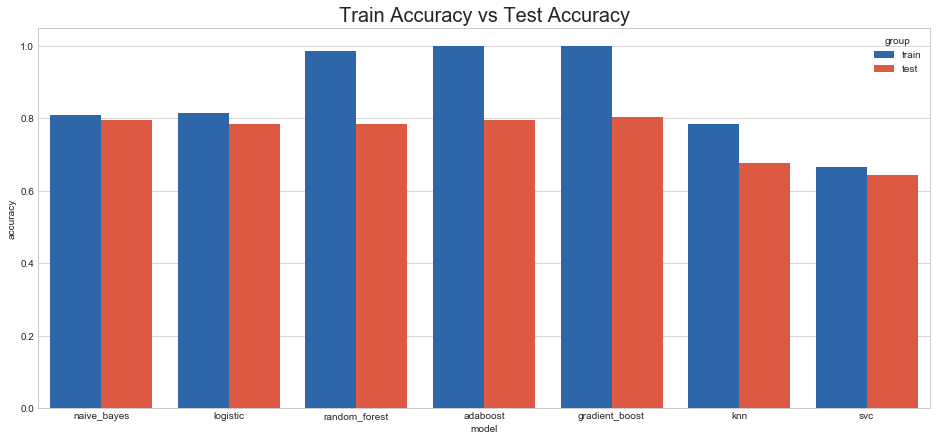

In [48]:
# Compare training and testing scores for accuracy
fig = plt.figure(figsize=(16,7))
sns.barplot(x='model', y='accuracy', data=baseline_avg_df, hue='group',  palette=['#1965bd', '#f5482a'])
plt.title('Train Accuracy vs Test Accuracy', fontsize=20)
plt.show()

The random forest, adaboost, and gradient boosting models display significant overfitting as their training scores averaged close to 100% accurate while their testing scores averaged closer to 80% accurate. This overfitting can be addressed with hyperparameter tuning/optimization. However, it is interesting to note that the naive bayes and logistic regression models achieved similar testing accuracy while displaying less overfitting. For this reason, it may be beneficial to include the naive bayes and logistic regression models instead of the random forest and adaboost models in subsequent iterations of model selection.

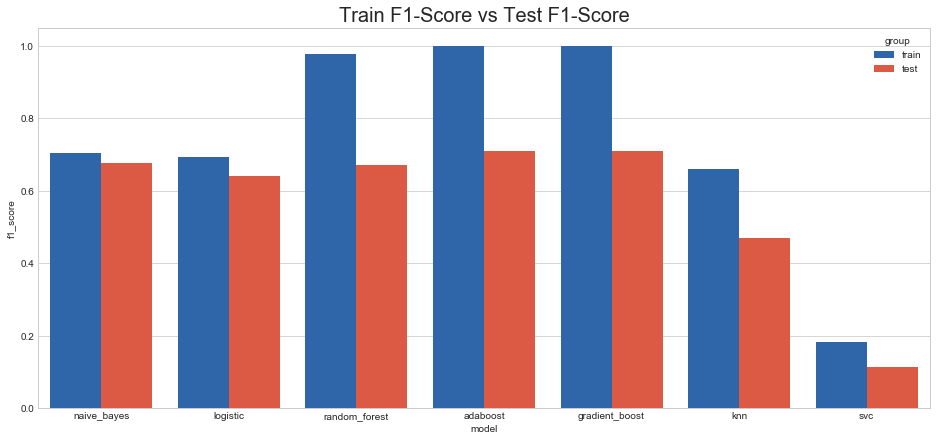

In [46]:
# Compare training and testing measures for F1-score

fig = plt.figure(figsize=(16,7))
sns.barplot(x='model', y='f1_score', data=baseline_avg_df, hue='group', palette=['#1965bd', '#f5482a'])
plt.title('Train F1-Score vs Test F1-Score', fontsize=20)
plt.show()

Again, the training F1-scores for the random forest, adaboost, and gradient boosting models are significantly higher than their testing value, further indicating overfitting to the training data. Naive bayes (0.676) slightly outperfroms the random forest (0.668) model with much less overfitting. This finding strengthens the conclusion to have the naive bayes model progress to subsequent iterations of model selection instead of the random forest model.

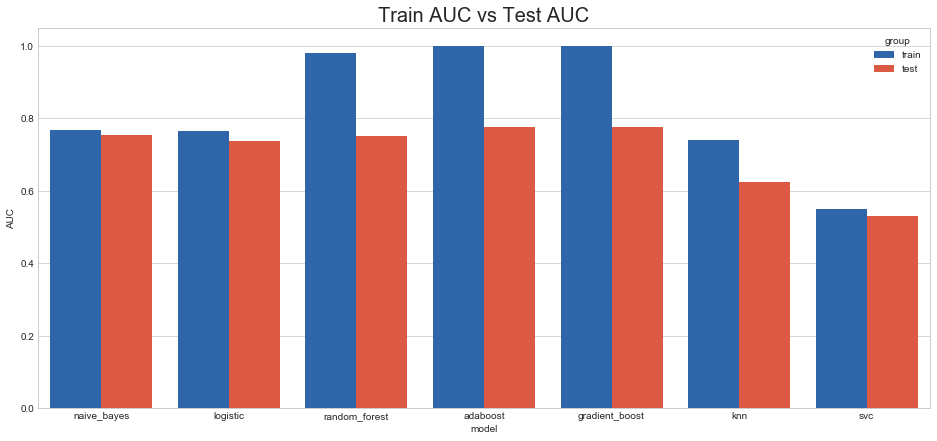

In [49]:
# Compare training and testing scores for AUC

fig = plt.figure(figsize=(16,7))
sns.barplot(x='model', y='AUC', data=baseline_avg_df, hue='group',  palette=['#1965bd', '#f5482a'])
plt.title('Train AUC vs Test AUC', fontsize=20)
plt.show()

Echoing the overfitting trends displayed in the figures for accuracy and F1-score, the random forest, adaboost, and gradient boosting models all have higher training AUC measures than their testing AUC measures. Additionally, the AUC measures for the naive bayes and logistic regression models are similar to the random forest model, but again with less overfitting. 

### Conclusion from Baseline Modeling

Based on analysis of the strength of each model's performance on the testing set and their evidence for overfitting, the gradient boosting, naive bayes, and logistic regression models will progress to subsequent iterations of model selection. Gradient boosting had the strongest performance of all the models, but it did display overfitting. Naive bayes and logistic regression performed similar to random forest and adaboost, but with less overfitting. The KNN and SVC models had the weakest performance across all measures.

## Model Tuning and Optimization

The naive bayes, logistic regression, and gradient boosting models will undergo hyperparameter tuning and optimization to limit overfitting and improve overall performance. They will again be evaluated based on accuracy, F1-score, and AUC.

# Project Summary

<img src="https://media.giphy.com/media/xUPGcoQ8sfEbaP2JYA/giphy.gif">

**Similar Project** https://www.dataquest.io/blog/shark-attack-data-rise-humans-impact-oceans/

In [74]:
import featuretools as ft

In [75]:
x2.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [76]:
x2.describe()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.133187,29.962308,6.551648,26.199711,38.295837,28.167618,67.678997
std,0.392210,0.111098,3.169533,4.462372,70.610488,2.377764,16.786865
min,0.000000,29.630000,1.300000,7.077778,2.666667,18.242222,3.000000
25%,0.000000,29.900000,4.300000,23.229444,10.577778,26.837778,62.642248
50%,0.000000,29.965000,5.900000,26.625556,15.865278,28.471111,70.800000
75%,0.057500,30.040000,7.875000,29.510000,31.638889,30.073889,76.633333
max,3.500000,30.200000,16.600000,34.023077,640.000000,31.708889,110.311111


In [111]:
ft_test = data_raw.copy()
ft_test.head()

,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,1,No,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,2,No,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,3,No,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,4,No,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,No,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [112]:
ft_test.loc[(ft_test.Attack == 'No'), 'Attack'] = 0
ft_test.loc[(ft_test.Attack == 'Yes'), 'Attack'] = 1
print(ft_test.Attack.unique())
ft_test.head()

[0 1]


,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,1,0,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,2,0,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,3,0,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,4,0,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,0,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [113]:
target = ft_test.Attack

In [114]:
ft_test = ft_test.drop(['Attack', 'MoonPhase', 'MoonPhaseExtended'], axis=1)
ft_test.head()

,X.2,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [115]:
es = ft.EntitySet(id = 'test1')
es.entity_from_dataframe(entity_id = 'raw1', 
                         dataframe = ft_test, 
                         index = 'X.2')
es.entity_from_dataframe(entity_id = 'raw2', 
                         dataframe = ft_test, 
                         index = 'X.2')

Entityset: test1
  Entities:
    raw1 [Rows: 182, Columns: 8]
    raw2 [Rows: 182, Columns: 8]
  Relationships:
    No relationships

In [116]:
# Create the relationships
relate = ft.Relationship(es['raw1']['X.2'], es['raw2']['X.2'])
es.add_relationship(relate)

es

Entityset: test1
  Entities:
    raw1 [Rows: 182, Columns: 8]
    raw2 [Rows: 182, Columns: 8]
  Relationships:
    raw2.X.2 -> raw1.X.2

In [124]:
# Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='raw1',
                                       max_depth = 3, 
                                       verbose = 1, 
                                       n_jobs = -1)

Built 49 features
EntitySet scattered to workers in 1.574 seconds
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [125]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,SUM(raw2.Precipitation_Value),SUM(raw2.StationPressure),SUM(raw2.WindSpeed),...,MIN(raw2.Turbidity),MIN(raw2.Temperature),MIN(raw2.DissovedO2),MEAN(raw2.Precipitation_Value),MEAN(raw2.StationPressure),MEAN(raw2.WindSpeed),MEAN(raw2.Salinity),MEAN(raw2.Turbidity),MEAN(raw2.Temperature),MEAN(raw2.DissovedO2)
X.2,,,,,,,,,,,,,,,,,,,,,
1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,0.00,29.96,6.4,...,23.422222,26.008889,82.555556,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0.19,30.00,4.4,...,26.844444,24.673333,75.444444,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0.00,29.92,7.5,...,20.266667,24.951111,78.511111,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0.00,29.92,5.4,...,15.488889,25.995556,87.644444,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0.00,29.98,7.2,...,44.733333,26.691111,91.244444,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [127]:
feature_matrix.isna().sum()

Precipitation_Value                 0
StationPressure                     0
WindSpeed                           0
Salinity                            0
Turbidity                           0
Temperature                         0
DissovedO2                          0
SUM(raw2.Precipitation_Value)       0
SUM(raw2.StationPressure)           0
SUM(raw2.WindSpeed)                 0
SUM(raw2.Salinity)                  0
SUM(raw2.Turbidity)                 0
SUM(raw2.Temperature)               0
SUM(raw2.DissovedO2)                0
STD(raw2.Precipitation_Value)     182
STD(raw2.StationPressure)         182
STD(raw2.WindSpeed)               182
STD(raw2.Salinity)                182
STD(raw2.Turbidity)               182
STD(raw2.Temperature)             182
STD(raw2.DissovedO2)              182
MAX(raw2.Precipitation_Value)       0
MAX(raw2.StationPressure)           0
MAX(raw2.WindSpeed)                 0
MAX(raw2.Salinity)                  0
MAX(raw2.Turbidity)                 0
MAX(raw2.Tem

In [128]:
feature_matrix = feature_matrix.dropna(axis=1)
feature_matrix.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,SUM(raw2.Precipitation_Value),SUM(raw2.StationPressure),SUM(raw2.WindSpeed),...,MIN(raw2.Turbidity),MIN(raw2.Temperature),MIN(raw2.DissovedO2),MEAN(raw2.Precipitation_Value),MEAN(raw2.StationPressure),MEAN(raw2.WindSpeed),MEAN(raw2.Salinity),MEAN(raw2.Turbidity),MEAN(raw2.Temperature),MEAN(raw2.DissovedO2)
X.2,,,,,,,,,,,,,,,,,,,,,
1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,0.00,29.96,6.4,...,23.422222,26.008889,82.555556,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0.19,30.00,4.4,...,26.844444,24.673333,75.444444,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0.00,29.92,7.5,...,20.266667,24.951111,78.511111,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0.00,29.92,5.4,...,15.488889,25.995556,87.644444,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0.00,29.98,7.2,...,44.733333,26.691111,91.244444,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [126]:
all_features

['Precipitation_Value',
 'StationPressure',
 'WindSpeed',
 'Salinity',
 'Turbidity',
 'Temperature',
 'DissovedO2',
 'SUM(raw2.Precipitation_Value)',
 'SUM(raw2.StationPressure)',
 'SUM(raw2.WindSpeed)',
 'SUM(raw2.Salinity)',
 'SUM(raw2.Turbidity)',
 'SUM(raw2.Temperature)',
 'SUM(raw2.DissovedO2)',
 'STD(raw2.Precipitation_Value)',
 'STD(raw2.StationPressure)',
 'STD(raw2.WindSpeed)',
 'STD(raw2.Salinity)',
 'STD(raw2.Turbidity)',
 'STD(raw2.Temperature)',
 'STD(raw2.DissovedO2)',
 'MAX(raw2.Precipitation_Value)',
 'MAX(raw2.StationPressure)',
 'MAX(raw2.WindSpeed)',
 'MAX(raw2.Salinity)',
 'MAX(raw2.Turbidity)',
 'MAX(raw2.Temperature)',
 'MAX(raw2.DissovedO2)',
 'SKEW(raw2.Precipitation_Value)',
 'SKEW(raw2.StationPressure)',
 'SKEW(raw2.WindSpeed)',
 'SKEW(raw2.Salinity)',
 'SKEW(raw2.Turbidity)',
 'SKEW(raw2.Temperature)',
 'SKEW(raw2.DissovedO2)',
 'MIN(raw2.Precipitation_Value)',
 'MIN(raw2.StationPressure)',
 'MIN(raw2.WindSpeed)',
 'MIN(raw2.Salinity)',
 'MIN(raw2.Turbidity)'

In [120]:
# Create correlation matrix
corr_matrix = feature_matrix.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

print('There are {} columns with >= 0.99 correlation.'.format(len(to_drop)))
to_drop

There are 28 columns with >= 0.99 correlation.


['SUM(raw2.Precipitation_Value)',
 'SUM(raw2.StationPressure)',
 'SUM(raw2.WindSpeed)',
 'SUM(raw2.Salinity)',
 'SUM(raw2.Turbidity)',
 'SUM(raw2.Temperature)',
 'SUM(raw2.DissovedO2)',
 'MAX(raw2.Precipitation_Value)',
 'MAX(raw2.StationPressure)',
 'MAX(raw2.WindSpeed)',
 'MAX(raw2.Salinity)',
 'MAX(raw2.Turbidity)',
 'MAX(raw2.Temperature)',
 'MAX(raw2.DissovedO2)',
 'MIN(raw2.Precipitation_Value)',
 'MIN(raw2.StationPressure)',
 'MIN(raw2.WindSpeed)',
 'MIN(raw2.Salinity)',
 'MIN(raw2.Turbidity)',
 'MIN(raw2.Temperature)',
 'MIN(raw2.DissovedO2)',
 'MEAN(raw2.Precipitation_Value)',
 'MEAN(raw2.StationPressure)',
 'MEAN(raw2.WindSpeed)',
 'MEAN(raw2.Salinity)',
 'MEAN(raw2.Turbidity)',
 'MEAN(raw2.Temperature)',
 'MEAN(raw2.DissovedO2)']

In [121]:
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]

In [123]:
feature_matrix.isna().sum()

Precipitation_Value                 0
StationPressure                     0
WindSpeed                           0
Salinity                            0
Turbidity                           0
Temperature                         0
DissovedO2                          0
STD(raw2.Precipitation_Value)     182
STD(raw2.StationPressure)         182
STD(raw2.WindSpeed)               182
STD(raw2.Salinity)                182
STD(raw2.Turbidity)               182
STD(raw2.Temperature)             182
STD(raw2.DissovedO2)              182
SKEW(raw2.Precipitation_Value)    182
SKEW(raw2.StationPressure)        182
SKEW(raw2.WindSpeed)              182
SKEW(raw2.Salinity)               182
SKEW(raw2.Turbidity)              182
SKEW(raw2.Temperature)            182
SKEW(raw2.DissovedO2)             182
dtype: int64

In [130]:
es = ft.EntitySet(id = 'test2')
es.entity_from_dataframe(entity_id = 'raw', 
                         dataframe = ft_test, 
                         index = 'X.2')

Entityset: test2
  Entities:
    raw [Rows: 182, Columns: 8]
  Relationships:
    No relationships

In [131]:
es.normalize_entity(base_entity_id='raw', 
                    new_entity_id='raw_norm', 
                    index = 'X.2')
es

Entityset: test2
  Entities:
    raw [Rows: 182, Columns: 8]
    raw_norm [Rows: 182, Columns: 1]
  Relationships:
    raw.X.2 -> raw_norm.X.2

In [132]:
# Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='raw',
                                       max_depth = 3, 
                                       verbose = True, 
                                       n_jobs = -1)

Built 49 features
EntitySet scattered to workers in 1.628 seconds
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [133]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,raw_norm.SUM(raw.Precipitation_Value),raw_norm.SUM(raw.StationPressure),raw_norm.SUM(raw.WindSpeed),...,raw_norm.MIN(raw.Turbidity),raw_norm.MIN(raw.Temperature),raw_norm.MIN(raw.DissovedO2),raw_norm.MEAN(raw.Precipitation_Value),raw_norm.MEAN(raw.StationPressure),raw_norm.MEAN(raw.WindSpeed),raw_norm.MEAN(raw.Salinity),raw_norm.MEAN(raw.Turbidity),raw_norm.MEAN(raw.Temperature),raw_norm.MEAN(raw.DissovedO2)
X.2,,,,,,,,,,,,,,,,,,,,,
1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,0.00,29.96,6.4,...,23.422222,26.008889,82.555556,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0.19,30.00,4.4,...,26.844444,24.673333,75.444444,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0.00,29.92,7.5,...,20.266667,24.951111,78.511111,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0.00,29.92,5.4,...,15.488889,25.995556,87.644444,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0.00,29.98,7.2,...,44.733333,26.691111,91.244444,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [160]:
test1 = pd.DataFrame(list(range(0,27)))
test2 = pd.DataFrame(list(np.random.normal(3,5,27)))
test3 = pd.DataFrame(list(np.random.normal(2,6,27)))
test4 = pd.DataFrame(list(np.random.normal(1,4,27)))
a_vals = pd.concat([test1,test2,test3,test4], axis=1)
a_vals.columns = ['id_1', 'feature_1', 'feature_2', 'feature_3']
a_vals.head()
# a = pd.DataFrame(a_vals, columns=['id_1', 'feature_1', 'feature_2', 'feature_3'])
# a.head()

,id_1,feature_1,feature_2,feature_3
0,0,3.575914,11.605245,-1.383500
1,1,7.786828,-8.599849,-4.794402
2,2,8.493551,-4.651412,0.810937
3,3,3.793781,-1.954862,-0.424732
4,4,4.586456,6.778380,-0.429188


In [161]:
test1 = pd.DataFrame(list(range(0,27)))
test2 = pd.DataFrame(list(np.random.normal(1,2,27)))
test3 = pd.DataFrame(list(np.random.normal(2,1,27)))
test4 = pd.DataFrame(list(np.random.normal(3,4,27)))
b_vals = pd.concat([test1,test2,test3,test4], axis=1)
b_vals.columns = ['id_2', 'feature_a', 'feature_b', 'feature_c']
b_vals.head()

,id_2,feature_a,feature_b,feature_c
0,0,-0.403382,2.547690,2.570069
1,1,-0.008833,1.568727,8.025109
2,2,0.226829,4.599408,-5.604052
3,3,-0.240256,0.655555,3.203800
4,4,4.552893,1.908055,1.681282


In [162]:
test1 = pd.DataFrame(list(range(0,27)))
test2 = pd.DataFrame(list(np.random.normal(1,2,27)))
test3 = pd.DataFrame(list(np.random.normal(2,1,27)))
test4 = pd.DataFrame(list(np.random.normal(3,4,27)))
c_vals = pd.concat([test1,test2,test3,test4], axis=1)
c_vals.columns = ['id_3', 'feature_x', 'feature_y', 'feature_z']
c_vals.head()

,id_3,feature_x,feature_y,feature_z
0,0,3.089049,2.986356,4.792806
1,1,1.826606,2.397190,-1.834298
2,2,4.043384,1.561233,7.808497
3,3,1.344552,0.596218,5.236397
4,4,2.893771,2.452087,9.691515


In [188]:
es = ft.EntitySet(id = 'example')
es.entity_from_dataframe(entity_id = 'entity_1', 
                         dataframe = a_vals, 
                         index = 'id_1')
es.entity_from_dataframe(entity_id = 'entity_2', 
                         dataframe = b_vals, 
                         index = 'id_2')
es.entity_from_dataframe(entity_id = 'entity_3', 
                         dataframe = c_vals, 
                         index = 'id_3')

Entityset: example
  Entities:
    entity_1 [Rows: 27, Columns: 4]
    entity_2 [Rows: 27, Columns: 4]
    entity_3 [Rows: 27, Columns: 4]
  Relationships:
    No relationships

In [189]:
# Create the relationships
relate1 = ft.Relationship(es['entity_1']['id_1'], es['entity_2']['id_2'])
es.add_relationship(relate1)
# Create the relationships
relate2 = ft.Relationship(es['entity_3']['id_3'], es['entity_2']['id_2'])
es.add_relationship(relate2)

es

Entityset: example
  Entities:
    entity_1 [Rows: 27, Columns: 4]
    entity_2 [Rows: 27, Columns: 4]
    entity_3 [Rows: 27, Columns: 4]
  Relationships:
    entity_2.id_2 -> entity_1.id_1
    entity_2.id_2 -> entity_3.id_3

In [191]:
# Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='entity_1',
                                       max_depth = 3, 
                                       verbose = True, 
                                       n_jobs = -1)

Built 147 features
EntitySet scattered to workers in 0.996 seconds


Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/3 chunks

Elapsed: 00:00 | Remaining: 00:00 | Progress:  33%|███▎      | Calculated: 1/3 chunks

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 3/3 chunks

In [179]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,feature_1,feature_2,feature_3,SUM(table_2.feature_a),SUM(table_2.feature_b),SUM(table_2.feature_c),STD(table_2.feature_a),STD(table_2.feature_b),STD(table_2.feature_c),MAX(table_2.feature_a),...,MEAN(table_2.table_3.MAX(table_2.feature_c)),MEAN(table_2.table_3.SKEW(table_2.feature_a)),MEAN(table_2.table_3.SKEW(table_2.feature_b)),MEAN(table_2.table_3.SKEW(table_2.feature_c)),MEAN(table_2.table_3.MIN(table_2.feature_a)),MEAN(table_2.table_3.MIN(table_2.feature_b)),MEAN(table_2.table_3.MIN(table_2.feature_c)),MEAN(table_2.table_3.MEAN(table_2.feature_a)),MEAN(table_2.table_3.MEAN(table_2.feature_b)),MEAN(table_2.table_3.MEAN(table_2.feature_c))
id_1,,,,,,,,,,,,,,,,,,,,,
0,3.575914,11.605245,-1.383500,-0.403382,2.547690,2.570069,NaN,NaN,NaN,-0.403382,...,2.570069,NaN,NaN,NaN,-0.403382,2.547690,2.570069,-0.403382,2.547690,2.570069
1,7.786828,-8.599849,-4.794402,-0.008833,1.568727,8.025109,NaN,NaN,NaN,-0.008833,...,8.025109,NaN,NaN,NaN,-0.008833,1.568727,8.025109,-0.008833,1.568727,8.025109
2,8.493551,-4.651412,0.810937,0.226829,4.599408,-5.604052,NaN,NaN,NaN,0.226829,...,-5.604052,NaN,NaN,NaN,0.226829,4.599408,-5.604052,0.226829,4.599408,-5.604052
3,3.793781,-1.954862,-0.424732,-0.240256,0.655555,3.203800,NaN,NaN,NaN,-0.240256,...,3.203800,NaN,NaN,NaN,-0.240256,0.655555,3.203800,-0.240256,0.655555,3.203800
4,4.586456,6.778380,-0.429188,4.552893,1.908055,1.681282,NaN,NaN,NaN,4.552893,...,1.681282,NaN,NaN,NaN,4.552893,1.908055,1.681282,4.552893,1.908055,1.681282


In [192]:
all_features[-35:]

['MIN(table_2.table_3.SUM(table_2.feature_b))',
 'MIN(table_2.table_3.SUM(table_2.feature_c))',
 'MIN(table_2.table_3.STD(table_2.feature_a))',
 'MIN(table_2.table_3.STD(table_2.feature_b))',
 'MIN(table_2.table_3.STD(table_2.feature_c))',
 'MIN(table_2.table_3.MAX(table_2.feature_a))',
 'MIN(table_2.table_3.MAX(table_2.feature_b))',
 'MIN(table_2.table_3.MAX(table_2.feature_c))',
 'MIN(table_2.table_3.SKEW(table_2.feature_a))',
 'MIN(table_2.table_3.SKEW(table_2.feature_b))',
 'MIN(table_2.table_3.SKEW(table_2.feature_c))',
 'MIN(table_2.table_3.MIN(table_2.feature_a))',
 'MIN(table_2.table_3.MIN(table_2.feature_b))',
 'MIN(table_2.table_3.MIN(table_2.feature_c))',
 'MIN(table_2.table_3.MEAN(table_2.feature_a))',
 'MIN(table_2.table_3.MEAN(table_2.feature_b))',
 'MIN(table_2.table_3.MEAN(table_2.feature_c))',
 'MEAN(table_2.table_3.SUM(table_2.feature_a))',
 'MEAN(table_2.table_3.SUM(table_2.feature_b))',
 'MEAN(table_2.table_3.SUM(table_2.feature_c))',
 'MEAN(table_2.table_3.STD(tabl

distributed.core - INFO - Event loop was unresponsive in Nanny for 847.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 413.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 13.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data

distributed.core - INFO - Event loop was unresponsive in Nanny for 108.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 291.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 34.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.54s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of dat

distributed.core - INFO - Event loop was unresponsive in Nanny for 42.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 412.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 412.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 21.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 241.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 295.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 423.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.98s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.44s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.48s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.64s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.67s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 283.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.12s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.31s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.33s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 71.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 71.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.60s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 989.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2259.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2259.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.00s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of 

distributed.core - INFO - Event loop was unresponsive in Nanny for 584.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.25s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.97s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 196.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This

distributed.core - INFO - Event loop was unresponsive in Nanny for 20.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 365.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.22s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.29s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 386.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.76s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.81s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.43s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.48s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.92s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.60s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.65s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.17s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.94s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data.

distributed.core - INFO - Event loop was unresponsive in Nanny for 34.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.69s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 33.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.05s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.20s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 138.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 66.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of d

distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.31s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 31.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.59s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 634.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 634.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 387.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 387.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data

distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.19s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.25s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.35s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.39s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 49 memory: 315 MB fds: 164>>
Traceback (most rece

distributed.core - INFO - Event loop was unresponsive in Nanny for 10.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.20s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 35.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 225.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 73.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 30.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.93s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of

distributed.core - INFO - Event loop was unresponsive in Nanny for 77.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.73s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.55s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 107.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 32.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 32.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.38s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 535.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 535.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 98.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 11.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.40s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.88s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.95s.  This is often caused by long-running GIL-holding functions or moving large chunks 

In [186]:
ft.primitives.list_primitives()[:10]

,name,type,description
0,num_unique,aggregation,"Determines the number of distinct values, igno..."
1,std,aggregation,Computes the dispersion relative to the mean v...
2,max,aggregation,"Calculates the highest value, ignoring `NaN` v..."
3,avg_time_between,aggregation,Computes the average number of seconds between...
4,skew,aggregation,Computes the extent to which a distribution di...
5,time_since_last,aggregation,Calculates the time elapsed since the last dat...
6,min,aggregation,"Calculates the smallest value, ignoring `NaN` ..."
7,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
8,count,aggregation,"Determines the total number of values, excludi..."
9,median,aggregation,Determines the middlemost number in a list of ...


In [69]:
x1 = pd.get_dummies(x1)
x1.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,MoonPhaseExtended_First quarter,MoonPhaseExtended_Full,MoonPhaseExtended_New,...,MoonPhaseExtended_Waxing crescent,MoonPhaseExtended_Waxing gibbous,MoonPhase_First quarter,MoonPhase_Full,MoonPhase_New,MoonPhase_Third quarter,MoonPhase_Waning crescent,MoonPhase_Waning gibbous,MoonPhase_Waxing crescent,MoonPhase_Waxing gibbous
0,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0,1,0,...,0,0,0,1,0,0,0,0,0,0
